In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import time
import os
import tflearn
from utils import *
os.environ["CUDA_VISIBLE_DEVICES"]='1'


In [2]:
mnist_data = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Residual Network

In [3]:
inputs = tf.placeholder(tf.float32, [None, 28, 28, 1], name='inputs')
targets = tf.placeholder(tf.float32, [None, 2], name='targets')
input_shortcut = tf.placeholder(tf.float32, [None, 2], name='input_shortcut')
train_flag = tf.placeholder(tf.bool, name='training')


net = tflearn.conv_2d(inputs, 64, 3, activation='relu', bias=False)
# Residual blocks
net = tflearn.residual_bottleneck(net, 3, 16, 64)
net = tflearn.residual_bottleneck(net, 1, 32, 128, downsample=True)
net = tflearn.residual_bottleneck(net, 2, 32, 128)
net = tflearn.residual_bottleneck(net, 1, 64, 256, downsample=True)
net = tflearn.residual_bottleneck(net, 2, 64, 256)
net = tflearn.batch_normalization(net)
net = tflearn.activation(net, 'relu')
net = tflearn.global_avg_pool(net)

net = tflearn.fully_connected(net, 200, activation='relu')
feature_transform = tflearn.fully_connected(net, 2, activation='relu')
output = dense_custom(tf.cond(train_flag, lambda: feature_transform,
                              lambda: input_shortcut),
                      2, 2, activation=None)

#This part is for computing the accuracy of this model
pred_y = tf.nn.softmax(output)
pred_y_true = tf.argmax(pred_y, 1)
y_true = tf.argmax(targets, 1)
correct_prediction = tf.equal(pred_y_true, y_true)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# loss function and optimizer
cost = tf.reduce_mean((tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=targets)))
optimizer = tf.train.AdamOptimizer(0.0001).minimize(cost)

all_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
last_layer_variables = filter(lambda x: 'Variable' in x.name, all_variables)
previous_layer_variables = filter(lambda x: 'Variable' not in x.name, all_variables)

optimizer_last_layer = tf.train.AdamOptimizer(0.0001).minimize(cost,
                        var_list = last_layer_variables)
optimizer_previous_layer = tf.train.AdamOptimizer(0.0001).minimize(cost,
                        var_list = previous_layer_variables)


# optimizer = tf.train.MomentumOptimizer(0.0001, 0.9).minimize(cost)
saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))

In [4]:
config = tf.ConfigProto()
config.log_device_placement=False
config.allow_soft_placement=True
config.gpu_options.allow_growth=True
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())

# Training helper functions

In [5]:
def get_2_class(imgs, labs):
    label = np.argmax(labs,1)
    index_0 = np.where(label==0)[0]
    index_1 = np.where(label==1)[0]
    index = list(index_0)+list(index_1)
    images = imgs[index]
    label = label[index]
    label = to_categorical(label, 2)
    return images, label

In [31]:
batch_size = 4096
def optmizer(optimizer_step, epochs):

    for i in (range(epochs)):
        epoch_loss = []
        start_epoch = time.time()
        for ii in range(mnist_data.train.num_examples//batch_size):
            batch = mnist_data.train.next_batch(batch_size)
            imgs = batch[0].reshape((-1, 28, 28, 1))
            labs = batch[1]
            imgs, labs = get_2_class(imgs, labs)

            dict_input = {inputs:imgs, targets:labs, train_flag: True, 
                         input_shortcut: np.zeros([batch_size, 2])}

            c, _ = session.run([cost, optimizer_step], feed_dict=dict_input)
            epoch_loss.append(c)
        print("Epoche: {}/{}".format(i+1, epochs), "| Training accuracy: ", session.run(accuracy, feed_dict=dict_input), 
              "| Cost: {}".format(np.mean(epoch_loss)), " | Time for epoch: {:.2f}s".format(time.time() - start_epoch))
        if i%100==0:
            saver.save(session,'../model/mnist_resnet_{}.ckpt'.format(i))

# Train and check

In [7]:
optmizer(optimizer, 1000)

('Epoche: 1/1000', '| Training accuracy: ', 0.48441243, '| Cost: 0.676861703396', ' | Time for epoch: 10.78s')
('Epoche: 2/1000', '| Training accuracy: ', 0.46875, '| Cost: 0.632158875465', ' | Time for epoch: 9.62s')
('Epoche: 3/1000', '| Training accuracy: ', 0.45838085, '| Cost: 0.563115954399', ' | Time for epoch: 9.19s')
('Epoche: 4/1000', '| Training accuracy: ', 0.9847596, '| Cost: 0.429897516966', ' | Time for epoch: 9.26s')
('Epoche: 5/1000', '| Training accuracy: ', 0.9917839, '| Cost: 0.393047779799', ' | Time for epoch: 9.17s')
('Epoche: 6/1000', '| Training accuracy: ', 0.98943657, '| Cost: 0.381394386292', ' | Time for epoch: 9.20s')
('Epoche: 7/1000', '| Training accuracy: ', 0.9897959, '| Cost: 0.379549920559', ' | Time for epoch: 9.20s')
('Epoche: 8/1000', '| Training accuracy: ', 0.9953051, '| Cost: 0.371042400599', ' | Time for epoch: 8.84s')
('Epoche: 9/1000', '| Training accuracy: ', 0.9964328, '| Cost: 0.367955207825', ' | Time for epoch: 9.38s')
('Epoche: 10/1000

('Epoche: 77/1000', '| Training accuracy: ', 0.99886495, '| Cost: 0.31743362546', ' | Time for epoch: 9.32s')
('Epoche: 78/1000', '| Training accuracy: ', 1.0, '| Cost: 0.316620230675', ' | Time for epoch: 9.32s')
('Epoche: 79/1000', '| Training accuracy: ', 1.0, '| Cost: 0.3157376647', ' | Time for epoch: 9.32s')
('Epoche: 80/1000', '| Training accuracy: ', 1.0, '| Cost: 0.315378129482', ' | Time for epoch: 10.12s')
('Epoche: 81/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.314517050982', ' | Time for epoch: 10.82s')
('Epoche: 82/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.315345138311', ' | Time for epoch: 10.11s')
('Epoche: 83/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.313499301672', ' | Time for epoch: 8.36s')
('Epoche: 84/1000', '| Training accuracy: ', 0.9988611, '| Cost: 0.313259541988', ' | Time for epoch: 8.36s')
('Epoche: 85/1000', '| Training accuracy: ', 1.0, '| Cost: 0.312479227781', ' | Time for epoch: 8.43s')
('Epoche: 86/1000', '| Training 

('Epoche: 153/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.274509906769', ' | Time for epoch: 8.72s')
('Epoche: 154/1000', '| Training accuracy: ', 0.9988317, '| Cost: 0.274057179689', ' | Time for epoch: 8.80s')
('Epoche: 155/1000', '| Training accuracy: ', 1.0, '| Cost: 0.274017959833', ' | Time for epoch: 8.70s')
('Epoche: 156/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.272728383541', ' | Time for epoch: 8.74s')
('Epoche: 157/1000', '| Training accuracy: ', 1.0, '| Cost: 0.272724419832', ' | Time for epoch: 8.89s')
('Epoche: 158/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.272010236979', ' | Time for epoch: 8.83s')
('Epoche: 159/1000', '| Training accuracy: ', 1.0, '| Cost: 0.272472679615', ' | Time for epoch: 8.67s')
('Epoche: 160/1000', '| Training accuracy: ', 0.9988179, '| Cost: 0.271887123585', ' | Time for epoch: 8.90s')
('Epoche: 161/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.270789653063', ' | Time for epoch: 8.69s')
('Epoche: 162/1000

('Epoche: 229/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.238047704101', ' | Time for epoch: 8.76s')
('Epoche: 230/1000', '| Training accuracy: ', 1.0, '| Cost: 0.237664803863', ' | Time for epoch: 8.63s')
('Epoche: 231/1000', '| Training accuracy: ', 1.0, '| Cost: 0.237797409296', ' | Time for epoch: 8.72s')
('Epoche: 232/1000', '| Training accuracy: ', 1.0, '| Cost: 0.23726426065', ' | Time for epoch: 8.70s')
('Epoche: 233/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.235968843102', ' | Time for epoch: 8.84s')
('Epoche: 234/1000', '| Training accuracy: ', 1.0, '| Cost: 0.235605552793', ' | Time for epoch: 8.81s')
('Epoche: 235/1000', '| Training accuracy: ', 1.0, '| Cost: 0.235244050622', ' | Time for epoch: 8.67s')
('Epoche: 236/1000', '| Training accuracy: ', 1.0, '| Cost: 0.235168486834', ' | Time for epoch: 8.76s')
('Epoche: 237/1000', '| Training accuracy: ', 1.0, '| Cost: 0.234083592892', ' | Time for epoch: 8.85s')
('Epoche: 238/1000', '| Training accuracy: 

('Epoche: 306/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.205716341734', ' | Time for epoch: 8.61s')
('Epoche: 307/1000', '| Training accuracy: ', 1.0, '| Cost: 0.204933434725', ' | Time for epoch: 8.78s')
('Epoche: 308/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.204856932163', ' | Time for epoch: 9.01s')
('Epoche: 309/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.204059258103', ' | Time for epoch: 8.69s')
('Epoche: 310/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.2039283216', ' | Time for epoch: 8.92s')
('Epoche: 311/1000', '| Training accuracy: ', 1.0, '| Cost: 0.203355371952', ' | Time for epoch: 8.76s')
('Epoche: 312/1000', '| Training accuracy: ', 1.0, '| Cost: 0.202828377485', ' | Time for epoch: 8.83s')
('Epoche: 313/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.202746942639', ' | Time for epoch: 8.49s')
('Epoche: 314/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.202501088381', ' | Time for epoch: 8.72s')
('Epoche: 315/1000

('Epoche: 382/1000', '| Training accuracy: ', 1.0, '| Cost: 0.177675098181', ' | Time for epoch: 8.73s')
('Epoche: 383/1000', '| Training accuracy: ', 0.9988426, '| Cost: 0.177379533648', ' | Time for epoch: 8.75s')
('Epoche: 384/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.177389636636', ' | Time for epoch: 8.78s')
('Epoche: 385/1000', '| Training accuracy: ', 1.0, '| Cost: 0.176709860563', ' | Time for epoch: 8.78s')
('Epoche: 386/1000', '| Training accuracy: ', 1.0, '| Cost: 0.176086097956', ' | Time for epoch: 8.75s')
('Epoche: 387/1000', '| Training accuracy: ', 1.0, '| Cost: 0.175482854247', ' | Time for epoch: 8.68s')
('Epoche: 388/1000', '| Training accuracy: ', 1.0, '| Cost: 0.175759583712', ' | Time for epoch: 8.81s')
('Epoche: 389/1000', '| Training accuracy: ', 1.0, '| Cost: 0.175438374281', ' | Time for epoch: 8.75s')
('Epoche: 390/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.175114125013', ' | Time for epoch: 8.73s')
('Epoche: 391/1000', '| Training acc

('Epoche: 458/1000', '| Training accuracy: ', 1.0, '| Cost: 0.15282727778', ' | Time for epoch: 8.79s')
('Epoche: 459/1000', '| Training accuracy: ', 1.0, '| Cost: 0.152812257409', ' | Time for epoch: 8.86s')
('Epoche: 460/1000', '| Training accuracy: ', 0.9988359, '| Cost: 0.152612745762', ' | Time for epoch: 8.74s')
('Epoche: 461/1000', '| Training accuracy: ', 1.0, '| Cost: 0.152188703418', ' | Time for epoch: 8.64s')
('Epoche: 462/1000', '| Training accuracy: ', 1.0, '| Cost: 0.151991412044', ' | Time for epoch: 8.96s')
('Epoche: 463/1000', '| Training accuracy: ', 1.0, '| Cost: 0.151566520333', ' | Time for epoch: 8.75s')
('Epoche: 464/1000', '| Training accuracy: ', 0.9988412, '| Cost: 0.151169016957', ' | Time for epoch: 8.66s')
('Epoche: 465/1000', '| Training accuracy: ', 1.0, '| Cost: 0.150875657797', ' | Time for epoch: 8.71s')
('Epoche: 466/1000', '| Training accuracy: ', 0.9988398, '| Cost: 0.150545209646', ' | Time for epoch: 8.77s')
('Epoche: 467/1000', '| Training accur

('Epoche: 534/1000', '| Training accuracy: ', 1.0, '| Cost: 0.131640017033', ' | Time for epoch: 8.77s')
('Epoche: 535/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.131249964237', ' | Time for epoch: 8.70s')
('Epoche: 536/1000', '| Training accuracy: ', 1.0, '| Cost: 0.130953654647', ' | Time for epoch: 8.69s')
('Epoche: 537/1000', '| Training accuracy: ', 1.0, '| Cost: 0.130536854267', ' | Time for epoch: 8.77s')
('Epoche: 538/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.130913838744', ' | Time for epoch: 8.74s')
('Epoche: 539/1000', '| Training accuracy: ', 1.0, '| Cost: 0.130517929792', ' | Time for epoch: 8.80s')
('Epoche: 540/1000', '| Training accuracy: ', 1.0, '| Cost: 0.130033135414', ' | Time for epoch: 8.95s')
('Epoche: 541/1000', '| Training accuracy: ', 0.9988839, '| Cost: 0.130079835653', ' | Time for epoch: 8.74s')
('Epoche: 542/1000', '| Training accuracy: ', 1.0, '| Cost: 0.129753693938', ' | Time for epoch: 8.75s')
('Epoche: 543/1000', '| Training accu

('Epoche: 611/1000', '| Training accuracy: ', 1.0, '| Cost: 0.112855874002', ' | Time for epoch: 8.72s')
('Epoche: 612/1000', '| Training accuracy: ', 1.0, '| Cost: 0.112848393619', ' | Time for epoch: 8.68s')
('Epoche: 613/1000', '| Training accuracy: ', 1.0, '| Cost: 0.112129643559', ' | Time for epoch: 8.64s')
('Epoche: 614/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.111952058971', ' | Time for epoch: 8.76s')
('Epoche: 615/1000', '| Training accuracy: ', 1.0, '| Cost: 0.111766494811', ' | Time for epoch: 8.76s')
('Epoche: 616/1000', '| Training accuracy: ', 1.0, '| Cost: 0.111344948411', ' | Time for epoch: 8.78s')
('Epoche: 617/1000', '| Training accuracy: ', 1.0, '| Cost: 0.111497096717', ' | Time for epoch: 8.78s')
('Epoche: 618/1000', '| Training accuracy: ', 1.0, '| Cost: 0.111014172435', ' | Time for epoch: 8.75s')
('Epoche: 619/1000', '| Training accuracy: ', 0.9988826, '| Cost: 0.110841661692', ' | Time for epoch: 8.81s')
('Epoche: 620/1000', '| Training accuracy: 

('Epoche: 687/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0967970192432', ' | Time for epoch: 8.66s')
('Epoche: 688/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0968281924725', ' | Time for epoch: 8.81s')
('Epoche: 689/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0964169055223', ' | Time for epoch: 8.80s')
('Epoche: 690/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0964657217264', ' | Time for epoch: 8.62s')
('Epoche: 691/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0958067476749', ' | Time for epoch: 8.92s')
('Epoche: 692/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0958004146814', ' | Time for epoch: 8.71s')
('Epoche: 693/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0958698615432', ' | Time for epoch: 8.74s')
('Epoche: 694/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0956660956144', ' | Time for epoch: 8.80s')
('Epoche: 695/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0954477787018', ' | Time for epoch: 8.71s')
('Epoche: 696/1000', '| Training 

('Epoche: 763/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0829214006662', ' | Time for epoch: 8.65s')
('Epoche: 764/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0830105617642', ' | Time for epoch: 8.71s')
('Epoche: 765/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0826417654753', ' | Time for epoch: 8.65s')
('Epoche: 766/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0822596997023', ' | Time for epoch: 8.61s')
('Epoche: 767/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0823383703828', ' | Time for epoch: 8.75s')
('Epoche: 768/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0821147486567', ' | Time for epoch: 8.81s')
('Epoche: 769/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0820836275816', ' | Time for epoch: 8.63s')
('Epoche: 770/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0817119553685', ' | Time for epoch: 8.74s')
('Epoche: 771/1000', '| Training accuracy: ', 1.0, '| Cost: 0.08172313869', ' | Time for epoch: 8.70s')
('Epoche: 772/1000', '

('Epoche: 839/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0711796656251', ' | Time for epoch: 8.72s')
('Epoche: 840/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0709039643407', ' | Time for epoch: 8.84s')
('Epoche: 841/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0709089934826', ' | Time for epoch: 8.64s')
('Epoche: 842/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0705330073833', ' | Time for epoch: 8.58s')
('Epoche: 843/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0703607946634', ' | Time for epoch: 8.67s')
('Epoche: 844/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0703329220414', ' | Time for epoch: 8.97s')
('Epoche: 845/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0702721327543', ' | Time for epoch: 8.81s')
('Epoche: 846/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0699733421206', ' | Time for epoch: 8.58s')
('Epoche: 847/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0700289309025', ' | Time for epoch: 8.81s')
('Epoche: 848/1000', '| Tr

('Epoche: 914/1000', '| Training accuracy: ', 0.998852, '| Cost: 0.0610327683389', ' | Time for epoch: 8.77s')
('Epoche: 915/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0608456768095', ' | Time for epoch: 8.67s')
('Epoche: 916/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0605512447655', ' | Time for epoch: 8.74s')
('Epoche: 917/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0607701987028', ' | Time for epoch: 8.67s')
('Epoche: 918/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0603894814849', ' | Time for epoch: 8.73s')
('Epoche: 919/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0604080408812', ' | Time for epoch: 8.81s')
('Epoche: 920/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0601899623871', ' | Time for epoch: 8.67s')
('Epoche: 921/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0600379705429', ' | Time for epoch: 8.93s')
('Epoche: 922/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0599806644022', ' | Time for epoch: 8.64s')
('Epoche: 923/1000', '| Training a

('Epoche: 990/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0521203055978', ' | Time for epoch: 8.91s')
('Epoche: 991/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0519885420799', ' | Time for epoch: 8.91s')
('Epoche: 992/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0518911294639', ' | Time for epoch: 8.75s')
('Epoche: 993/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0517647080123', ' | Time for epoch: 8.71s')
('Epoche: 994/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0516068600118', ' | Time for epoch: 8.84s')
('Epoche: 995/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0516439713538', ' | Time for epoch: 8.69s')
('Epoche: 996/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0515883713961', ' | Time for epoch: 8.73s')
('Epoche: 997/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0513501614332', ' | Time for epoch: 8.68s')
('Epoche: 998/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0513128377497', ' | Time for epoch: 8.69s')
('Epoche: 999/1000'

In [17]:
optmizer(optimizer, 1001)

('Epoche: 1/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0510262399912', ' | Time for epoch: 8.04s')
('Epoche: 2/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.0508619397879', ' | Time for epoch: 7.97s')
('Epoche: 3/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0508486069739', ' | Time for epoch: 8.02s')
('Epoche: 4/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0506962612271', ' | Time for epoch: 8.01s')
('Epoche: 5/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.0506035126746', ' | Time for epoch: 8.03s')
('Epoche: 6/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0504418686032', ' | Time for epoch: 8.05s')
('Epoche: 7/1001', '| Training accuracy: ', 1.0000001, '| Cost: 0.0503722839057', ' | Time for epoch: 8.10s')
('Epoche: 8/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0502222925425', ' | Time for epoch: 8.08s')
('Epoche: 9/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0501823797822', ' | Time for epoch: 8.12s')
('Epoche: 10/1001', '| Training accuracy: ',

('Epoche: 78/1001', '| Training accuracy: ', 0.9988038, '| Cost: 0.0434531830251', ' | Time for epoch: 8.55s')
('Epoche: 79/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.0433711744845', ' | Time for epoch: 8.44s')
('Epoche: 80/1001', '| Training accuracy: ', 0.99880666, '| Cost: 0.0431579127908', ' | Time for epoch: 8.39s')
('Epoche: 81/1001', '| Training accuracy: ', 0.9999999, '| Cost: 0.0431965999305', ' | Time for epoch: 8.38s')
('Epoche: 82/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0430125743151', ' | Time for epoch: 8.54s')
('Epoche: 83/1001', '| Training accuracy: ', 1.0, '| Cost: 0.043009582907', ' | Time for epoch: 8.50s')
('Epoche: 84/1001', '| Training accuracy: ', 0.9999999, '| Cost: 0.0428771972656', ' | Time for epoch: 8.55s')
('Epoche: 85/1001', '| Training accuracy: ', 1.0, '| Cost: 0.042727317661', ' | Time for epoch: 8.44s')
('Epoche: 86/1001', '| Training accuracy: ', 0.9988452, '| Cost: 0.0426398739219', ' | Time for epoch: 8.77s')
('Epoche: 87/1001',

('Epoche: 154/1001', '| Training accuracy: ', 0.9988864, '| Cost: 0.0372349284589', ' | Time for epoch: 8.51s')
('Epoche: 155/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0370174497366', ' | Time for epoch: 8.59s')
('Epoche: 156/1001', '| Training accuracy: ', 0.99889135, '| Cost: 0.0367790199816', ' | Time for epoch: 8.36s')
('Epoche: 157/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.0368357487023', ' | Time for epoch: 8.56s')
('Epoche: 158/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0369109883904', ' | Time for epoch: 8.62s')
('Epoche: 159/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0366870127618', ' | Time for epoch: 8.41s')
('Epoche: 160/1001', '| Training accuracy: ', 0.9988519, '| Cost: 0.0365629270673', ' | Time for epoch: 8.77s')
('Epoche: 161/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0365525223315', ' | Time for epoch: 8.55s')
('Epoche: 162/1001', '| Training accuracy: ', 1.0000001, '| Cost: 0.0365175753832', ' | Time for epoch: 8.51s')
('Epoche: 163/

('Epoche: 230/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.0316655896604', ' | Time for epoch: 8.66s')
('Epoche: 231/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0316514000297', ' | Time for epoch: 8.41s')
('Epoche: 232/1001', '| Training accuracy: ', 0.9988545, '| Cost: 0.0315572470427', ' | Time for epoch: 8.70s')
('Epoche: 233/1001', '| Training accuracy: ', 0.9988165, '| Cost: 0.0316350832582', ' | Time for epoch: 8.69s')
('Epoche: 234/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0314198285341', ' | Time for epoch: 8.70s')
('Epoche: 235/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0313039794564', ' | Time for epoch: 8.49s')
('Epoche: 236/1001', '| Training accuracy: ', 1.0000001, '| Cost: 0.0312415994704', ' | Time for epoch: 8.60s')
('Epoche: 237/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0312310922891', ' | Time for epoch: 8.44s')
('Epoche: 238/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.0311327744275', ' | Time for epoch: 8.61s')
('Epoche: 239/

('Epoche: 306/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.0270502045751', ' | Time for epoch: 8.76s')
('Epoche: 307/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.027008254081', ' | Time for epoch: 8.57s')
('Epoche: 308/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0269964206964', ' | Time for epoch: 8.61s')
('Epoche: 309/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.0268605537713', ' | Time for epoch: 8.46s')
('Epoche: 310/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0268656704575', ' | Time for epoch: 8.42s')
('Epoche: 311/1001', '| Training accuracy: ', 0.9988777, '| Cost: 0.0267005171627', ' | Time for epoch: 8.45s')
('Epoche: 312/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.0267382394522', ' | Time for epoch: 8.62s')
('Epoche: 313/1001', '| Training accuracy: ', 0.9999999, '| Cost: 0.0267116557807', ' | Time for epoch: 8.76s')
('Epoche: 314/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.0265413932502', ' | Time for epoch: 8.53s')


('Epoche: 382/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0231561195105', ' | Time for epoch: 8.51s')
('Epoche: 383/1001', '| Training accuracy: ', 1.0000001, '| Cost: 0.0230245608836', ' | Time for epoch: 8.61s')
('Epoche: 384/1001', '| Training accuracy: ', 0.99887127, '| Cost: 0.0229668226093', ' | Time for epoch: 8.73s')
('Epoche: 385/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.0229333713651', ' | Time for epoch: 8.46s')
('Epoche: 386/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.0229230020195', ' | Time for epoch: 8.71s')
('Epoche: 387/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.0229109246284', ' | Time for epoch: 8.54s')
('Epoche: 388/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0228094663471', ' | Time for epoch: 8.50s')
('Epoche: 389/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0227806977928', ' | Time for epoch: 8.62s')
('Epoche: 390/1001', '| Training accuracy: ', 1.0, '| Cost: 0.022745013237', ' | Time for epoch: 8.62s')
('Epoche: 391

('Epoche: 458/1001', '| Training accuracy: ', 1.0000001, '| Cost: 0.01981039159', ' | Time for epoch: 8.48s')
('Epoche: 459/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.0197185389698', ' | Time for epoch: 8.37s')
('Epoche: 460/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0196308232844', ' | Time for epoch: 8.44s')
('Epoche: 461/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.0196977481246', ' | Time for epoch: 8.73s')
('Epoche: 462/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0195681955665', ' | Time for epoch: 8.63s')
('Epoche: 463/1001', '| Training accuracy: ', 0.9999999, '| Cost: 0.0195261463523', ' | Time for epoch: 8.68s')
('Epoche: 464/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0194463897496', ' | Time for epoch: 8.53s')
('Epoche: 465/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.0194218773395', ' | Time for epoch: 8.45s')
('Epoche: 466/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0193696003407', ' | Time for epoch: 8.53s')
('Epoche: 467/1

('Epoche: 534/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.0168479420245', ' | Time for epoch: 8.41s')
('Epoche: 535/1001', '| Training accuracy: ', 1.0000001, '| Cost: 0.0168294161558', ' | Time for epoch: 8.58s')
('Epoche: 536/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0168148297817', ' | Time for epoch: 8.75s')
('Epoche: 537/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.0167534425855', ' | Time for epoch: 8.65s')
('Epoche: 538/1001', '| Training accuracy: ', 1.0, '| Cost: 0.016736779362', ' | Time for epoch: 8.51s')
('Epoche: 539/1001', '| Training accuracy: ', 0.998852, '| Cost: 0.0166855920106', ' | Time for epoch: 8.66s')
('Epoche: 540/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0166559740901', ' | Time for epoch: 8.57s')
('Epoche: 541/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0166559200734', ' | Time for epoch: 8.63s')
('Epoche: 542/1001', '| Training accuracy: ', 1.0000001, '| Cost: 0.0166384652257', ' | Time for epoch: 8.56s')
('Epoche: 543/10

('Epoche: 610/1001', '| Training accuracy: ', 0.9999999, '| Cost: 0.014428017661', ' | Time for epoch: 8.59s')
('Epoche: 611/1001', '| Training accuracy: ', 1.0000001, '| Cost: 0.0143955014646', ' | Time for epoch: 8.40s')
('Epoche: 612/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0143808536232', ' | Time for epoch: 8.69s')
('Epoche: 613/1001', '| Training accuracy: ', 1.0000001, '| Cost: 0.0143636744469', ' | Time for epoch: 8.46s')
('Epoche: 614/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.0142884198576', ' | Time for epoch: 8.66s')
('Epoche: 615/1001', '| Training accuracy: ', 0.9988333, '| Cost: 0.0142643898726', ' | Time for epoch: 8.48s')
('Epoche: 616/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.0142316259444', ' | Time for epoch: 8.73s')
('Epoche: 617/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0142306340858', ' | Time for epoch: 8.36s')
('Epoche: 618/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0141883473843', ' | Time for epoch: 8.80s')
('Epoche:

('Epoche: 686/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.0123597187921', ' | Time for epoch: 8.69s')
('Epoche: 687/1001', '| Training accuracy: ', 1.0000001, '| Cost: 0.0123098352924', ' | Time for epoch: 8.43s')
('Epoche: 688/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0122837731615', ' | Time for epoch: 8.63s')
('Epoche: 689/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0122544234619', ' | Time for epoch: 8.65s')
('Epoche: 690/1001', '| Training accuracy: ', 1.0, '| Cost: 0.012239921838', ' | Time for epoch: 8.69s')
('Epoche: 691/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.012246449478', ' | Time for epoch: 8.58s')
('Epoche: 692/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0121859395877', ' | Time for epoch: 8.57s')
('Epoche: 693/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0121560189873', ' | Time for epoch: 8.35s')
('Epoche: 694/1001', '| Training accuracy: ', 0.9988571, '| Cost: 0.0121589619666', ' | Time for epoch: 8.53s')
('Epoche: 695/1001', '

('Epoche: 762/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0106120612472', ' | Time for epoch: 8.43s')
('Epoche: 763/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0105297863483', ' | Time for epoch: 8.43s')
('Epoche: 764/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.0105165485293', ' | Time for epoch: 8.34s')
('Epoche: 765/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.0105439731851', ' | Time for epoch: 8.74s')
('Epoche: 766/1001', '| Training accuracy: ', 0.9999999, '| Cost: 0.0144394049421', ' | Time for epoch: 8.71s')
('Epoche: 767/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0111253112555', ' | Time for epoch: 8.61s')
('Epoche: 768/1001', '| Training accuracy: ', 0.998779, '| Cost: 0.0136527204886', ' | Time for epoch: 8.63s')
('Epoche: 769/1001', '| Training accuracy: ', 1.0000001, '| Cost: 0.0123789701611', ' | Time for epoch: 8.52s')
('Epoche: 770/1001', '| Training accuracy: ', 0.9988439, '| Cost: 0.0107594868168', ' | Time for epoch: 8.45s')
('Epoche:

('Epoche: 838/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00907223299146', ' | Time for epoch: 8.57s')
('Epoche: 839/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.0090997107327', ' | Time for epoch: 8.52s')
('Epoche: 840/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00901747308671', ' | Time for epoch: 8.83s')
('Epoche: 841/1001', '| Training accuracy: ', 1.0000001, '| Cost: 0.00905024912208', ' | Time for epoch: 8.49s')
('Epoche: 842/1001', '| Training accuracy: ', 1.0000001, '| Cost: 0.0090172206983', ' | Time for epoch: 8.54s')
('Epoche: 843/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00898679532111', ' | Time for epoch: 8.64s')
('Epoche: 844/1001', '| Training accuracy: ', 0.9999999, '| Cost: 0.00896000489593', ' | Time for epoch: 8.63s')
('Epoche: 845/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00892561208457', ' | Time for epoch: 8.46s')
('Epoche: 846/1001', '| Training accuracy: ', 0.9988439, '| Cost: 0.00891580991447', ' | Time for epoch: 8.55s')
('Epoche

('Epoche: 913/1001', '| Training accuracy: ', 0.9999999, '| Cost: 0.00741872983053', ' | Time for epoch: 8.60s')
('Epoche: 914/1001', '| Training accuracy: ', 0.9988276, '| Cost: 0.0077989352867', ' | Time for epoch: 8.57s')
('Epoche: 915/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.00777794234455', ' | Time for epoch: 8.67s')
('Epoche: 916/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00771028734744', ' | Time for epoch: 8.46s')
('Epoche: 917/1001', '| Training accuracy: ', 1.0000001, '| Cost: 0.0077329678461', ' | Time for epoch: 8.53s')
('Epoche: 918/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00773154012859', ' | Time for epoch: 8.74s')
('Epoche: 919/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.00733224255964', ' | Time for epoch: 8.59s')
('Epoche: 920/1001', '| Training accuracy: ', 1.0000001, '| Cost: 0.0073290723376', ' | Time for epoch: 8.69s')
('Epoche: 921/1001', '| Training accuracy: ', 1.0000001, '| Cost: 0.00770133268088', ' | Time for epoch: 8.73

('Epoche: 988/1001', '| Training accuracy: ', 0.9999999, '| Cost: 0.00671970285475', ' | Time for epoch: 8.73s')
('Epoche: 989/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.00671194726601', ' | Time for epoch: 8.46s')
('Epoche: 990/1001', '| Training accuracy: ', 0.9988726, '| Cost: 0.00668754754588', ' | Time for epoch: 8.49s')
('Epoche: 991/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00667854910716', ' | Time for epoch: 8.79s')
('Epoche: 992/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.00627603847533', ' | Time for epoch: 8.87s')
('Epoche: 993/1001', '| Training accuracy: ', 0.9999999, '| Cost: 0.00667444616556', ' | Time for epoch: 8.48s')
('Epoche: 994/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00665609445423', ' | Time for epoch: 8.51s')
('Epoche: 995/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00624915864319', ' | Time for epoch: 8.66s')
('Epoche: 996/1001', '| Training accuracy: ', 1.0000001, '| Cost: 0.00664052041247', ' | Time for epoch: 8.33s')

In [29]:
def adam_variables_initializer(adam_opt, var_list):
    adam_vars = [adam_opt.get_slot(var, name)
                 for name in adam_opt.get_slot_names()
                 for var in var_list if var is not None]
    adam_vars.extend(list(adam_opt._get_beta_accumulators()))
    return tf.variables_initializer(adam_vars)

In [30]:
all_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
last_layer_variables = filter(lambda x: 'Variable' in x.name, all_variables)
previous_layer_variables = filter(lambda x: 'Variable' not in x.name, all_variables)

optimizer_last_layer = tf.train.AdamOptimizer(0.0001)
step_last_layer = optimizer_last_layer.minimize(cost,
                        var_list = last_layer_variables)

reset_opt_vars = adam_variables_initializer(optimizer_last_layer,
                                            last_layer_variables)
session.run(reset_opt_vars)

In [63]:
optimizer_sgd_last_layer = tf.train.GradientDescentOptimizer(1e-6)
step_sgd_last_layer = optimizer_sgd_last_layer.minimize(cost,
                        var_list = last_layer_variables)
reset_opt_op = tf.variables_initializer([optimizer_sgd_last_layer.get_slot(var, name) 
                for name in optimizer_sgd_last_layer.get_slot_names() for var in last_layer_variables])
session.run(reset_opt_op)

In [37]:
optmizer(step_last_layer, 1000)

('Epoche: 1/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.00522957742214', ' | Time for epoch: 1.11s')
('Epoche: 2/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00522827357054', ' | Time for epoch: 1.07s')
('Epoche: 3/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00520744919777', ' | Time for epoch: 1.12s')
('Epoche: 4/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00518657499924', ' | Time for epoch: 1.12s')
('Epoche: 5/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.00519072310999', ' | Time for epoch: 1.11s')
('Epoche: 6/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00519232917577', ' | Time for epoch: 1.11s')
('Epoche: 7/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.00513966893777', ' | Time for epoch: 1.16s')
('Epoche: 8/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0051481006667', ' | Time for epoch: 1.11s')
('Epoche: 9/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00515021430328', ' | Time for epoch: 1.09s')
('Epoche: 10/1000', '| Training

('Epoche: 77/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.00447859195992', ' | Time for epoch: 1.08s')
('Epoche: 78/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00443855579942', ' | Time for epoch: 1.12s')
('Epoche: 79/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00444285292178', ' | Time for epoch: 1.12s')
('Epoche: 80/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00444060144946', ' | Time for epoch: 1.14s')
('Epoche: 81/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00443796254694', ' | Time for epoch: 1.10s')
('Epoche: 82/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00442644488066', ' | Time for epoch: 1.15s')
('Epoche: 83/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0044267536141', ' | Time for epoch: 1.13s')
('Epoche: 84/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0044355308637', ' | Time for epoch: 1.15s')
('Epoche: 85/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.00442941486835', ' | Time for epoch: 1.11s')
('Epoche: 86/1000', '| 

('Epoche: 153/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00387129979208', ' | Time for epoch: 1.11s')
('Epoche: 154/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.00385731458664', ' | Time for epoch: 1.08s')
('Epoche: 155/1000', '| Training accuracy: ', 0.99881935, '| Cost: 0.00386455701664', ' | Time for epoch: 1.13s')
('Epoche: 156/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0038607751485', ' | Time for epoch: 1.13s')
('Epoche: 157/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00385163142346', ' | Time for epoch: 1.16s')
('Epoche: 158/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0038068681024', ' | Time for epoch: 1.08s')
('Epoche: 159/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.00382403912954', ' | Time for epoch: 1.09s')
('Epoche: 160/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00382462749258', ' | Time for epoch: 1.11s')
('Epoche: 161/1000', '| Training accuracy: ', 0.9988138, '| Cost: 0.00380892585963', ' | Time for epoch: 1.07s')
(

('Epoche: 228/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.00290662748739', ' | Time for epoch: 1.10s')
('Epoche: 229/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00337252137251', ' | Time for epoch: 1.14s')
('Epoche: 230/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00338638806716', ' | Time for epoch: 1.13s')
('Epoche: 231/1000', '| Training accuracy: ', 0.99886876, '| Cost: 0.00334784924053', ' | Time for epoch: 1.09s')
('Epoche: 232/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00337430555373', ' | Time for epoch: 1.08s')
('Epoche: 233/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00335651286878', ' | Time for epoch: 1.13s')
('Epoche: 234/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00333010777831', ' | Time for epoch: 1.09s')
('Epoche: 235/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00334206968546', ' | Time for epoch: 1.10s')
('Epoche: 236/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00332469982095', ' | Time for epoch: 1.11s')
('Epoche: 

('Epoche: 303/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00296421069652', ' | Time for epoch: 1.12s')
('Epoche: 304/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0029464114923', ' | Time for epoch: 1.08s')
('Epoche: 305/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00294336327352', ' | Time for epoch: 1.10s')
('Epoche: 306/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00293503329158', ' | Time for epoch: 1.11s')
('Epoche: 307/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00296103814617', ' | Time for epoch: 1.07s')
('Epoche: 308/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00291923549958', ' | Time for epoch: 1.07s')
('Epoche: 309/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00291862082668', ' | Time for epoch: 1.12s')
('Epoche: 310/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.00292944861576', ' | Time for epoch: 1.10s')
('Epoche: 311/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00293529080227', ' | Time for epoch: 1.13s')
('Epoche: 312/1000', '| T

('Epoche: 378/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00260483520105', ' | Time for epoch: 1.14s')
('Epoche: 379/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00260523962788', ' | Time for epoch: 1.09s')
('Epoche: 380/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.00261964602396', ' | Time for epoch: 1.08s')
('Epoche: 381/1000', '| Training accuracy: ', 0.9988492, '| Cost: 0.00259146792814', ' | Time for epoch: 1.12s')
('Epoche: 382/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00256998068653', ' | Time for epoch: 1.10s')
('Epoche: 383/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00259895646013', ' | Time for epoch: 1.12s')
('Epoche: 384/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00257228733972', ' | Time for epoch: 1.09s')
('Epoche: 385/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00258521409705', ' | Time for epoch: 1.10s')
('Epoche: 386/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0025677154772', ' | Time for epoch: 1.10s')
('Epoche: 387/1000', '| Tr

('Epoche: 453/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00231216591783', ' | Time for epoch: 1.11s')
('Epoche: 454/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00231654057279', ' | Time for epoch: 1.11s')
('Epoche: 455/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.00227505713701', ' | Time for epoch: 1.10s')
('Epoche: 456/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00180005293805', ' | Time for epoch: 1.07s')
('Epoche: 457/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00228867330588', ' | Time for epoch: 1.09s')
('Epoche: 458/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00229446962476', ' | Time for epoch: 1.11s')
('Epoche: 459/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00229623564519', ' | Time for epoch: 1.11s')
('Epoche: 460/1000', '| Training accuracy: ', 0.99888754, '| Cost: 0.00226922426373', ' | Time for epoch: 1.12s')
('Epoche: 461/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.00227064453065', ' | Time for epoch: 1.06s')
('Ep

('Epoche: 528/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.00206750724465', ' | Time for epoch: 1.11s')
('Epoche: 529/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.00207060785033', ' | Time for epoch: 1.09s')
('Epoche: 530/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00206549651921', ' | Time for epoch: 1.09s')
('Epoche: 531/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.00204293383285', ' | Time for epoch: 1.08s')
('Epoche: 532/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00204180530272', ' | Time for epoch: 1.07s')
('Epoche: 533/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00204610289074', ' | Time for epoch: 1.10s')
('Epoche: 534/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.00206624739803', ' | Time for epoch: 1.11s')
('Epoche: 535/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00203057471663', ' | Time for epoch: 1.07s')
('Epoche: 536/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00204725726508', ' | Time for epoch: 1.11s')
('Epoche: 537

('Epoche: 603/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0018527401844', ' | Time for epoch: 1.13s')
('Epoche: 604/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00182856223546', ' | Time for epoch: 1.10s')
('Epoche: 605/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00186203769408', ' | Time for epoch: 1.11s')
('Epoche: 606/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0018676596228', ' | Time for epoch: 1.10s')
('Epoche: 607/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.00184816063847', ' | Time for epoch: 1.13s')
('Epoche: 608/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00185422797222', ' | Time for epoch: 1.09s')
('Epoche: 609/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00189230707474', ' | Time for epoch: 1.08s')
('Epoche: 610/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00184348342009', ' | Time for epoch: 1.13s')
('Epoche: 611/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00185392738786', ' | Time for epoch: 1.10s')
('Epoche: 61

('Epoche: 678/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.00167582428548', ' | Time for epoch: 1.08s')
('Epoche: 679/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00164637365378', ' | Time for epoch: 1.12s')
('Epoche: 680/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00166932446882', ' | Time for epoch: 1.09s')
('Epoche: 681/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00166331685614', ' | Time for epoch: 1.14s')
('Epoche: 682/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0016847300576', ' | Time for epoch: 1.11s')
('Epoche: 683/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.00168709014542', ' | Time for epoch: 1.12s')
('Epoche: 684/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00164849660359', ' | Time for epoch: 1.13s')
('Epoche: 685/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00169209600426', ' | Time for epoch: 1.11s')
('Epoche: 686/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.00166439497843', ' | Time for epoch: 1.09s')
('Epoc

('Epoche: 753/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00156203727238', ' | Time for epoch: 1.12s')
('Epoche: 754/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00150712998584', ' | Time for epoch: 1.11s')
('Epoche: 755/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.00152463279665', ' | Time for epoch: 1.10s')
('Epoche: 756/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00151276343968', ' | Time for epoch: 1.10s')
('Epoche: 757/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00151900097262', ' | Time for epoch: 1.09s')
('Epoche: 758/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00152337364852', ' | Time for epoch: 1.08s')
('Epoche: 759/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00153231562581', ' | Time for epoch: 1.11s')
('Epoche: 760/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00151232327335', ' | Time for epoch: 1.09s')
('Epoche: 761/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00153517327271', ' | Time for epoch: 1.08s')
('Epoche: 

('Epoche: 828/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000833831669297', ' | Time for epoch: 1.08s')
('Epoche: 829/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00142577651422', ' | Time for epoch: 1.13s')
('Epoche: 830/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00139769597445', ' | Time for epoch: 1.10s')
('Epoche: 831/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00142905919347', ' | Time for epoch: 1.09s')
('Epoche: 832/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.00139972020406', ' | Time for epoch: 1.11s')
('Epoche: 833/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000826006114949', ' | Time for epoch: 1.09s')
('Epoche: 834/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00139390036929', ' | Time for epoch: 1.10s')
('Epoche: 835/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.00138092588168', ' | Time for epoch: 1.09s')
('Epoche: 836/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.00141348759644', ' | Time for epoch: 1.07s

('Epoche: 903/1000', '| Training accuracy: ', 0.9988165, '| Cost: 0.00131919351406', ' | Time for epoch: 1.08s')
('Epoche: 904/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.00132184103131', ' | Time for epoch: 1.13s')
('Epoche: 905/1000', '| Training accuracy: ', 0.9988506, '| Cost: 0.0012997383019', ' | Time for epoch: 1.10s')
('Epoche: 906/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0012703979155', ' | Time for epoch: 1.09s')
('Epoche: 907/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.00129942968488', ' | Time for epoch: 1.08s')
('Epoche: 908/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0012758487137', ' | Time for epoch: 1.08s')
('Epoche: 909/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00129557016771', ' | Time for epoch: 1.12s')
('Epoche: 910/1000', '| Training accuracy: ', 0.9987951, '| Cost: 0.00132039014716', ' | Time for epoch: 1.09s')
('Epoche: 911/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00128000089899', ' | Time for epoch: 1.09s')
('Epoche: 

('Epoche: 978/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00119221769273', ' | Time for epoch: 1.12s')
('Epoche: 979/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00120680045802', ' | Time for epoch: 1.10s')
('Epoche: 980/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00119500199798', ' | Time for epoch: 1.12s')
('Epoche: 981/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0012363611022', ' | Time for epoch: 1.08s')
('Epoche: 982/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00120958581101', ' | Time for epoch: 1.07s')
('Epoche: 983/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00121518399101', ' | Time for epoch: 1.12s')
('Epoche: 984/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00120505946688', ' | Time for epoch: 1.10s')
('Epoche: 985/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00120495317969', ' | Time for epoch: 1.11s')
('Epoche: 986/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00120494072326', ' | Time for epoch: 1.10s')
('Epoche: 987/1000', '| Training accur

In [45]:
optmizer(step_last_layer, 2000)

('Epoche: 1/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00122352619655', ' | Time for epoch: 1.08s')
('Epoche: 2/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00122337543871', ' | Time for epoch: 1.04s')
('Epoche: 3/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0012186988024', ' | Time for epoch: 1.06s')
('Epoche: 4/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00120803085156', ' | Time for epoch: 1.07s')
('Epoche: 5/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00120330229402', ' | Time for epoch: 1.08s')
('Epoche: 6/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00120802666061', ' | Time for epoch: 1.10s')
('Epoche: 7/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00119085249025', ' | Time for epoch: 1.07s')
('Epoche: 8/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00118997122627', ' | Time for epoch: 1.07s')
('Epoche: 9/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000585540721659', ' | Time for epoch: 1.07s')
('Epoche: 10/2000', '| Training accuracy: 

('Epoche: 77/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00111261673737', ' | Time for epoch: 1.12s')
('Epoche: 78/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00112496456131', ' | Time for epoch: 1.08s')
('Epoche: 79/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00110662321094', ' | Time for epoch: 1.08s')
('Epoche: 80/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0011112135835', ' | Time for epoch: 1.13s')
('Epoche: 81/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00113470514771', ' | Time for epoch: 1.11s')
('Epoche: 82/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.00111465808004', ' | Time for epoch: 1.13s')
('Epoche: 83/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00110671215225', ' | Time for epoch: 1.09s')
('Epoche: 84/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00112011726014', ' | Time for epoch: 1.10s')
('Epoche: 85/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00112890684977', ' | Time for epoch: 1.09s')
('Epoche: 86/2000', '| Trai

('Epoche: 152/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00107682228554', ' | Time for epoch: 1.11s')
('Epoche: 153/2000', '| Training accuracy: ', 1.0, '| Cost: 0.0010903920047', ' | Time for epoch: 1.13s')
('Epoche: 154/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00109026313294', ' | Time for epoch: 1.09s')
('Epoche: 155/2000', '| Training accuracy: ', 1.0, '| Cost: 0.0010569805745', ' | Time for epoch: 1.14s')
('Epoche: 156/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.00107517582364', ' | Time for epoch: 1.11s')
('Epoche: 157/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00107349455357', ' | Time for epoch: 1.08s')
('Epoche: 158/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00105937989429', ' | Time for epoch: 1.12s')
('Epoche: 159/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.00104956550058', ' | Time for epoch: 1.08s')
('Epoche: 160/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00104767351877', ' | Time for epoch: 1.10s')
('Epoche: 161/2000',

('Epoche: 227/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00105887046084', ' | Time for epoch: 1.07s')
('Epoche: 228/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.00103094486985', ' | Time for epoch: 1.11s')
('Epoche: 229/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00101194193121', ' | Time for epoch: 1.11s')
('Epoche: 230/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00106560532004', ' | Time for epoch: 1.10s')
('Epoche: 231/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00104797608219', ' | Time for epoch: 1.14s')
('Epoche: 232/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00102875230368', ' | Time for epoch: 1.06s')
('Epoche: 233/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00100475747604', ' | Time for epoch: 1.12s')
('Epoche: 234/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.00108578242362', ' | Time for epoch: 1.11s')
('Epoche: 235/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00102860736661', ' | Time for epoch: 1.10s')
('Epoche: 236/2000', '| T

('Epoche: 302/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00100540334824', ' | Time for epoch: 1.09s')
('Epoche: 303/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00101887830533', ' | Time for epoch: 1.06s')
('Epoche: 304/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000349700276274', ' | Time for epoch: 1.11s')
('Epoche: 305/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000996433314867', ' | Time for epoch: 1.08s')
('Epoche: 306/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000987845356576', ' | Time for epoch: 1.11s')
('Epoche: 307/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000947490916587', ' | Time for epoch: 1.12s')
('Epoche: 308/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.00102963671088', ' | Time for epoch: 1.08s')
('Epoche: 309/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000994661590084', ' | Time for epoch: 1.11s')
('Epoche: 310/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000347635272192', ' | Time for epoch: 1.09s')
('Ep

('Epoche: 376/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000977888936177', ' | Time for epoch: 1.11s')
('Epoche: 377/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000957633485086', ' | Time for epoch: 1.11s')
('Epoche: 378/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000986870145425', ' | Time for epoch: 1.09s')
('Epoche: 379/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.00100199272856', ' | Time for epoch: 1.11s')
('Epoche: 380/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00101720809471', ' | Time for epoch: 1.08s')
('Epoche: 381/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000957056588959', ' | Time for epoch: 1.12s')
('Epoche: 382/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000311287440127', ' | Time for epoch: 1.13s')
('Epoche: 383/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000994601752609', ' | Time for epoch: 1.11s')
('Epoche: 384/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00098592962604', ' | Time for e

('Epoche: 451/2000', '| Training accuracy: ', 0.99884796, '| Cost: 0.000951480353251', ' | Time for epoch: 1.09s')
('Epoche: 452/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000945342821069', ' | Time for epoch: 1.09s')
('Epoche: 453/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000957340875175', ' | Time for epoch: 1.13s')
('Epoche: 454/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000921092520002', ' | Time for epoch: 1.12s')
('Epoche: 455/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000965751009062', ' | Time for epoch: 1.10s')
('Epoche: 456/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00095727504231', ' | Time for epoch: 1.09s')
('Epoche: 457/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000958544493187', ' | Time for epoch: 1.11s')
('Epoche: 458/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000935163407121', ' | Time for epoch: 1.10s')
('Epoche: 459/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000928119232412', ' | Time 

('Epoche: 526/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000987312290817', ' | Time for epoch: 1.12s')
('Epoche: 527/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000963491387665', ' | Time for epoch: 1.11s')
('Epoche: 528/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000932197959628', ' | Time for epoch: 1.08s')
('Epoche: 529/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000255356077105', ' | Time for epoch: 1.09s')
('Epoche: 530/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00090974860359', ' | Time for epoch: 1.11s')
('Epoche: 531/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000930452719331', ' | Time for epoch: 1.08s')
('Epoche: 532/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000911629991606', ' | Time for epoch: 1.12s')
('Epoche: 533/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000959835073445', ' | Time for epoch: 1.11s')
('Epoche: 534/2000', '| Training accuracy: ', 0.9988889, '| Cost: 0.000907583278604', ' | Time for epoch: 1.12s

('Epoche: 601/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000925927772187', ' | Time for epoch: 1.08s')
('Epoche: 602/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000931799411774', ' | Time for epoch: 1.08s')
('Epoche: 603/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000909544003662', ' | Time for epoch: 1.08s')
('Epoche: 604/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000235089391936', ' | Time for epoch: 1.12s')
('Epoche: 605/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000947399064898', ' | Time for epoch: 1.13s')
('Epoche: 606/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000919914746191', ' | Time for epoch: 1.15s')
('Epoche: 607/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000912494957447', ' | Time for epoch: 1.11s')
('Epoche: 608/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000919717480429', ' | Time for epoch: 1.16s')
('Epoche: 609/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000896713056136', ' | Time for epoch: 1.1

('Epoche: 675/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000894924392924', ' | Time for epoch: 1.11s')
('Epoche: 676/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000915684038773', ' | Time for epoch: 1.11s')
('Epoche: 677/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000895336386748', ' | Time for epoch: 1.08s')
('Epoche: 678/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000898816273548', ' | Time for epoch: 1.12s')
('Epoche: 679/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000917100929655', ' | Time for epoch: 1.08s')
('Epoche: 680/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000909110123757', ' | Time for epoch: 1.11s')
('Epoche: 681/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.00092508434318', ' | Time for epoch: 1.10s')
('Epoche: 682/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000955581665039', ' | Time for epoch: 1.11s')
('Epoche: 683/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000215876207221', ' | Time for epoch: 

('Epoche: 749/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000899473612662', ' | Time for epoch: 1.11s')
('Epoche: 750/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000935977324843', ' | Time for epoch: 1.09s')
('Epoche: 751/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000888189359102', ' | Time for epoch: 1.07s')
('Epoche: 752/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000879936444107', ' | Time for epoch: 1.11s')
('Epoche: 753/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000848713738378', ' | Time for epoch: 1.11s')
('Epoche: 754/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000911077368073', ' | Time for epoch: 1.08s')
('Epoche: 755/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000889263057616', ' | Time for epoch: 1.10s')
('Epoche: 756/2000', '| Training accuracy: ', 1.0, '| Cost: 0.0008770271088', ' | Time for epoch: 1.08s')
('Epoche: 757/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000200719281565', ' | Time for epoch: 1.07s'

('Epoche: 824/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000931611924898', ' | Time for epoch: 1.11s')
('Epoche: 825/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00087277503917', ' | Time for epoch: 1.07s')
('Epoche: 826/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000919529527891', ' | Time for epoch: 1.11s')
('Epoche: 827/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000888558919542', ' | Time for epoch: 1.12s')
('Epoche: 828/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000934851414058', ' | Time for epoch: 1.10s')
('Epoche: 829/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00092150666751', ' | Time for epoch: 1.13s')
('Epoche: 830/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000876200792845', ' | Time for epoch: 1.05s')
('Epoche: 831/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000900820130482', ' | Time for epoch: 1.05s')
('Epoche: 832/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000927400658838', ' | Time for epoch: 1.12s')
('Epoche: 833/20

('Epoche: 899/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00088384677656', ' | Time for epoch: 1.08s')
('Epoche: 900/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000879155821167', ' | Time for epoch: 1.11s')
('Epoche: 901/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000881746120285', ' | Time for epoch: 1.10s')
('Epoche: 902/2000', '| Training accuracy: ', 0.9988466, '| Cost: 0.000888425740413', ' | Time for epoch: 1.10s')
('Epoche: 903/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000897251593415', ' | Time for epoch: 1.10s')
('Epoche: 904/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000931248418055', ' | Time for epoch: 1.07s')
('Epoche: 905/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000867037917487', ' | Time for epoch: 1.12s')
('Epoche: 906/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000885606219526', ' | Time for epoch: 1.10s')
('Epoche: 907/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000888197100721', ' | Time for epoch: 1.10s')
('Epoche: 

('Epoche: 973/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000874199555255', ' | Time for epoch: 1.12s')
('Epoche: 974/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000891051138751', ' | Time for epoch: 1.11s')
('Epoche: 975/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000876818201505', ' | Time for epoch: 1.08s')
('Epoche: 976/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000919191224966', ' | Time for epoch: 1.07s')
('Epoche: 977/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000890790077392', ' | Time for epoch: 1.11s')
('Epoche: 978/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000871546799317', ' | Time for epoch: 1.08s')
('Epoche: 979/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00088772631716', ' | Time for epoch: 1.11s')
('Epoche: 980/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000884077919181', ' | Time for epoch: 1.14s')
('Epoche: 981/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000870544987265', ' | Time for epoch: 1.12s')
('Epoche: 

('Epoche: 1047/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000839503598399', ' | Time for epoch: 1.08s')
('Epoche: 1048/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000873431039508', ' | Time for epoch: 1.11s')
('Epoche: 1049/2000', '| Training accuracy: ', 0.99883723, '| Cost: 0.000885989400558', ' | Time for epoch: 1.13s')
('Epoche: 1050/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000864964793436', ' | Time for epoch: 1.12s')
('Epoche: 1051/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000887341273483', ' | Time for epoch: 1.11s')
('Epoche: 1052/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000865226204041', ' | Time for epoch: 1.08s')
('Epoche: 1053/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000861613894813', ' | Time for epoch: 1.07s')
('Epoche: 1054/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000884822860826', ' | Time for epoch: 1.10s')
('Epoche: 1055/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000886803783942', ' | Time for e

('Epoche: 1121/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000893638236448', ' | Time for epoch: 1.08s')
('Epoche: 1122/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000913908123039', ' | Time for epoch: 1.07s')
('Epoche: 1123/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000846053357236', ' | Time for epoch: 1.09s')
('Epoche: 1124/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000887778936885', ' | Time for epoch: 1.13s')
('Epoche: 1125/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000893214601092', ' | Time for epoch: 1.08s')
('Epoche: 1126/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000919314683415', ' | Time for epoch: 1.11s')
('Epoche: 1127/2000', '| Training accuracy: ', 0.99886364, '| Cost: 0.000866159156431', ' | Time for epoch: 1.08s')
('Epoche: 1128/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000893493241165', ' | Time for epoch: 1.07s')
('Epoche: 1129/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000849842908792', ' | Time for epo

('Epoche: 1195/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000857613689732', ' | Time for epoch: 1.08s')
('Epoche: 1196/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000904219166841', ' | Time for epoch: 1.12s')
('Epoche: 1197/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000880055536982', ' | Time for epoch: 1.11s')
('Epoche: 1198/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000855602265801', ' | Time for epoch: 1.13s')
('Epoche: 1199/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000873850658536', ' | Time for epoch: 1.07s')
('Epoche: 1200/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00090252381051', ' | Time for epoch: 1.08s')
('Epoche: 1201/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000898775702808', ' | Time for epoch: 1.11s')
('Epoche: 1202/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000904035230633', ' | Time for epoch: 1.09s')
('Epoche: 1203/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000900254992303', ' | Time for epoch: 1.1

('Epoche: 1269/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000885275600012', ' | Time for epoch: 1.09s')
('Epoche: 1270/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000843406363856', ' | Time for epoch: 1.11s')
('Epoche: 1271/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000881664163899', ' | Time for epoch: 1.10s')
('Epoche: 1272/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000910604256205', ' | Time for epoch: 1.07s')
('Epoche: 1273/2000', '| Training accuracy: ', 0.9987937, '| Cost: 0.000906005443539', ' | Time for epoch: 1.14s')
('Epoche: 1274/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000855829333887', ' | Time for epoch: 1.13s')
('Epoche: 1275/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000896572135389', ' | Time for epoch: 1.14s')
('Epoche: 1276/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000868120230734', ' | Time for epoch: 1.09s')
('Epoche: 1277/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000873842975125', ' | Time for epoch: 1

('Epoche: 1343/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000849931151606', ' | Time for epoch: 1.13s')
('Epoche: 1344/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000899436068721', ' | Time for epoch: 1.10s')
('Epoche: 1345/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000884434208274', ' | Time for epoch: 1.11s')
('Epoche: 1346/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000875665748026', ' | Time for epoch: 1.12s')
('Epoche: 1347/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000910554663278', ' | Time for epoch: 1.09s')
('Epoche: 1348/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000868068309501', ' | Time for epoch: 1.11s')
('Epoche: 1349/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000874573597685', ' | Time for epoch: 1.05s')
('Epoche: 1350/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000899141537957', ' | Time for epoch: 1.08s')
('Epoche: 1351/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000830058124848', ' | Time for epoch: 1.08s')

('Epoche: 1417/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000888465263415', ' | Time for epoch: 1.10s')
('Epoche: 1418/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000869866111316', ' | Time for epoch: 1.13s')
('Epoche: 1419/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000875905680005', ' | Time for epoch: 1.08s')
('Epoche: 1420/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000852733850479', ' | Time for epoch: 1.13s')
('Epoche: 1421/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000898532336578', ' | Time for epoch: 1.09s')
('Epoche: 1422/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000877651677001', ' | Time for epoch: 1.11s')
('Epoche: 1423/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000870347605087', ' | Time for epoch: 1.09s')
('Epoche: 1424/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00013363979815', ' | Time for epoch: 1.11s')
('Epoche: 1425/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000878962688148', ' | Time for epo

('Epoche: 1491/2000', '| Training accuracy: ', 1.0, '| Cost: 0.0008636333514', ' | Time for epoch: 1.09s')
('Epoche: 1492/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.00085899955593', ' | Time for epoch: 1.09s')
('Epoche: 1493/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000874766090419', ' | Time for epoch: 1.12s')
('Epoche: 1494/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000869512499776', ' | Time for epoch: 1.07s')
('Epoche: 1495/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000897133722901', ' | Time for epoch: 1.10s')
('Epoche: 1496/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000863747554831', ' | Time for epoch: 1.12s')
('Epoche: 1497/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000881943560671', ' | Time for epoch: 1.07s')
('Epoche: 1498/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000833733647596', ' | Time for epoch: 1.09s')
('Epoche: 1499/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000856159662362', ' | Time for epoch: 1.12s')
('Ep

('Epoche: 1565/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00086192053277', ' | Time for epoch: 1.11s')
('Epoche: 1566/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000860055210069', ' | Time for epoch: 1.10s')
('Epoche: 1567/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000851843506098', ' | Time for epoch: 1.09s')
('Epoche: 1568/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000900037877727', ' | Time for epoch: 1.13s')
('Epoche: 1569/2000', '| Training accuracy: ', 0.9988675, '| Cost: 0.000853269069921', ' | Time for epoch: 1.10s')
('Epoche: 1570/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000883504049852', ' | Time for epoch: 1.09s')
('Epoche: 1571/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000895070028491', ' | Time for epoch: 1.12s')
('Epoche: 1572/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000875463709235', ' | Time for epoch: 1.08s')
('Epoche: 1573/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000885194865987', ' | Time f

('Epoche: 1639/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000860918604303', ' | Time for epoch: 1.12s')
('Epoche: 1640/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000851797463838', ' | Time for epoch: 1.12s')
('Epoche: 1641/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000897636869922', ' | Time for epoch: 1.12s')
('Epoche: 1642/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.00086763832951', ' | Time for epoch: 1.10s')
('Epoche: 1643/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000887868518475', ' | Time for epoch: 1.13s')
('Epoche: 1644/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000882687279955', ' | Time for epoch: 1.09s')
('Epoche: 1645/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000877492013387', ' | Time for epoch: 1.07s')
('Epoche: 1646/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000846180482768', ' | Time for epoch: 1.10s')
('Epoche: 1647/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00088781316299', ' | Time for epoch: 1.0

('Epoche: 1713/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000853080884553', ' | Time for epoch: 1.09s')
('Epoche: 1714/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000893003947567', ' | Time for epoch: 1.16s')
('Epoche: 1715/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000885290384758', ' | Time for epoch: 1.10s')
('Epoche: 1716/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000878331891727', ' | Time for epoch: 1.14s')
('Epoche: 1717/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000868631817866', ' | Time for epoch: 1.13s')
('Epoche: 1718/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000856427883264', ' | Time for epoch: 1.13s')
('Epoche: 1719/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000869552372023', ' | Time for epoch: 1.06s')
('Epoche: 1720/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000862431828864', ' | Time for epoch: 1.13s')
('Epoche: 1721/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000859138264786', ' | Time for epoch: 1.11s')


('Epoche: 1787/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000878669205122', ' | Time for epoch: 1.11s')
('Epoche: 1788/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000846924027428', ' | Time for epoch: 1.12s')
('Epoche: 1789/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000118308518722', ' | Time for epoch: 1.13s')
('Epoche: 1790/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000866356655024', ' | Time for epoch: 1.13s')
('Epoche: 1791/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000916167977266', ' | Time for epoch: 1.11s')
('Epoche: 1792/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000879280851223', ' | Time for epoch: 1.11s')
('Epoche: 1793/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000856150931213', ' | Time for epoch: 1.12s')
('Epoche: 1794/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00087122595869', ' | Time for epoch: 1.08s')
('Epoche: 1795/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000872943899594', ' | Time for ep

('Epoche: 1861/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000841474276967', ' | Time for epoch: 1.10s')
('Epoche: 1862/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000858759623952', ' | Time for epoch: 1.09s')
('Epoche: 1863/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00091951910872', ' | Time for epoch: 1.07s')
('Epoche: 1864/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000841366127133', ' | Time for epoch: 1.09s')
('Epoche: 1865/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.00083404808538', ' | Time for epoch: 1.09s')
('Epoche: 1866/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000819848733954', ' | Time for epoch: 1.08s')
('Epoche: 1867/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000913473893888', ' | Time for epoch: 1.11s')
('Epoche: 1868/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000897930643987', ' | Time for epoch: 1.10s')
('Epoche: 1869/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000908519083168', ' | Time for epoc

('Epoche: 1935/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000833499478176', ' | Time for epoch: 1.10s')
('Epoche: 1936/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000853316043504', ' | Time for epoch: 1.11s')
('Epoche: 1937/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000861481647007', ' | Time for epoch: 1.07s')
('Epoche: 1938/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000854214944411', ' | Time for epoch: 1.14s')
('Epoche: 1939/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000853261677548', ' | Time for epoch: 1.13s')
('Epoche: 1940/2000', '| Training accuracy: ', 0.9988332, '| Cost: 0.000872230099048', ' | Time for epoch: 1.14s')
('Epoche: 1941/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000903285457753', ' | Time for epoch: 1.08s')
('Epoche: 1942/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000873075448908', ' | Time for epoch: 1.06s')
('Epoche: 1943/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000867422670126', ' | Time for epoch: 1

In [49]:
optmizer(step_last_layer, 2000)

('Epoche: 1/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000866398913786', ' | Time for epoch: 1.11s')
('Epoche: 2/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000111928355182', ' | Time for epoch: 1.04s')
('Epoche: 3/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000886975147296', ' | Time for epoch: 1.07s')
('Epoche: 4/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000871638534591', ' | Time for epoch: 1.08s')
('Epoche: 5/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00086401833687', ' | Time for epoch: 1.09s')
('Epoche: 6/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000904510437977', ' | Time for epoch: 1.08s')
('Epoche: 7/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000849726609886', ' | Time for epoch: 1.07s')
('Epoche: 8/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000867284485139', ' | Time for epoch: 1.06s')
('Epoche: 9/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000896642217413', ' | Time for epoch: 1.06s')
('Epoche: 10/2000', '

('Epoche: 76/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000864744535647', ' | Time for epoch: 1.08s')
('Epoche: 77/2000', '| Training accuracy: ', 0.9988385, '| Cost: 0.000867869122885', ' | Time for epoch: 1.12s')
('Epoche: 78/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00088881875854', ' | Time for epoch: 1.11s')
('Epoche: 79/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000823038048111', ' | Time for epoch: 1.09s')
('Epoche: 80/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000841149536427', ' | Time for epoch: 1.11s')
('Epoche: 81/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000852323428262', ' | Time for epoch: 1.07s')
('Epoche: 82/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000882494612597', ' | Time for epoch: 1.08s')
('Epoche: 83/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000845794915222', ' | Time for epoch: 1.13s')
('Epoche: 84/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.00083367706975', ' | Time for epoch: 1.11s')
('Epoche: 85/20

('Epoche: 151/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000841338711325', ' | Time for epoch: 1.08s')
('Epoche: 152/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000881081796251', ' | Time for epoch: 1.12s')
('Epoche: 153/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000837656087242', ' | Time for epoch: 1.09s')
('Epoche: 154/2000', '| Training accuracy: ', 0.9987909, '| Cost: 0.000898810045328', ' | Time for epoch: 1.11s')
('Epoche: 155/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000860624248162', ' | Time for epoch: 1.11s')
('Epoche: 156/2000', '| Training accuracy: ', 0.9988398, '| Cost: 0.000866775633767', ' | Time for epoch: 1.07s')
('Epoche: 157/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000894119380973', ' | Time for epoch: 1.12s')
('Epoche: 158/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000896120734978', ' | Time for epoch: 1.09s')
('Epoche: 159/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000871100986842', ' | Time for epoch: 1.09s')
('Epoche:

('Epoche: 226/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000862992252223', ' | Time for epoch: 1.09s')
('Epoche: 227/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000881804677192', ' | Time for epoch: 1.12s')
('Epoche: 228/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00085173395928', ' | Time for epoch: 1.08s')
('Epoche: 229/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000874385295901', ' | Time for epoch: 1.09s')
('Epoche: 230/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000867366848979', ' | Time for epoch: 1.11s')
('Epoche: 231/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000882776337676', ' | Time for epoch: 1.08s')
('Epoche: 232/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000869944691658', ' | Time for epoch: 1.07s')
('Epoche: 233/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000860271102283', ' | Time for epoch: 1.12s')
('Epoche: 234/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000835371436551', ' | Time for epo

('Epoche: 300/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000877111568116', ' | Time for epoch: 1.05s')
('Epoche: 301/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000860259809997', ' | Time for epoch: 1.12s')
('Epoche: 302/2000', '| Training accuracy: ', 0.9988611, '| Cost: 0.000852343218867', ' | Time for epoch: 1.10s')
('Epoche: 303/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000906364002731', ' | Time for epoch: 1.10s')
('Epoche: 304/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000855835853145', ' | Time for epoch: 1.08s')
('Epoche: 305/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000907437526621', ' | Time for epoch: 1.08s')
('Epoche: 306/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000834168924484', ' | Time for epoch: 1.08s')
('Epoche: 307/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000875014811754', ' | Time for epoch: 1.07s')
('Epoche: 308/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000878833176102', ' | Time for epoch: 1.1

('Epoche: 374/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00087422109209', ' | Time for epoch: 1.11s')
('Epoche: 375/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000882319232915', ' | Time for epoch: 1.13s')
('Epoche: 376/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000832246616483', ' | Time for epoch: 1.08s')
('Epoche: 377/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000881375686731', ' | Time for epoch: 1.08s')
('Epoche: 378/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000887030328158', ' | Time for epoch: 1.09s')
('Epoche: 379/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00088593683904', ' | Time for epoch: 1.08s')
('Epoche: 380/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000864383822773', ' | Time for epoch: 1.09s')
('Epoche: 381/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000851875520311', ' | Time for epoch: 1.13s')
('Epoche: 382/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00082977238344', ' | Time for epoch: 1.11s')
('Epoche: 383/2000', '| Trainin

('Epoche: 449/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000905690423679', ' | Time for epoch: 1.10s')
('Epoche: 450/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000897298916243', ' | Time for epoch: 1.13s')
('Epoche: 451/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000873135402799', ' | Time for epoch: 1.09s')
('Epoche: 452/2000', '| Training accuracy: ', 0.998895, '| Cost: 0.000829944794532', ' | Time for epoch: 1.13s')
('Epoche: 453/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000866843969561', ' | Time for epoch: 1.09s')
('Epoche: 454/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000905892811716', ' | Time for epoch: 1.11s')
('Epoche: 455/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000840477936435', ' | Time for epoch: 1.09s')
('Epoche: 456/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000878594117239', ' | Time for epoch: 1.08s')
('Epoche: 457/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000859131978359', ' | Time for epoch: 1.11s')

('Epoche: 523/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000882149324752', ' | Time for epoch: 1.11s')
('Epoche: 524/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000903945823666', ' | Time for epoch: 1.09s')
('Epoche: 525/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000835182552692', ' | Time for epoch: 1.11s')
('Epoche: 526/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000882874359377', ' | Time for epoch: 1.07s')
('Epoche: 527/2000', '| Training accuracy: ', 0.9988713, '| Cost: 0.000845021568239', ' | Time for epoch: 1.07s')
('Epoche: 528/2000', '| Training accuracy: ', 0.99884915, '| Cost: 0.000859932159074', ' | Time for epoch: 1.10s')
('Epoche: 529/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000904622778762', ' | Time for epoch: 1.11s')
('Epoche: 530/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000859067891724', ' | Time for epoch: 1.09s')
('Epoche: 531/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000835443963297', ' | Time for epoch: 1.13s')
('

('Epoche: 597/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000883824191988', ' | Time for epoch: 1.11s')
('Epoche: 598/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000873739598319', ' | Time for epoch: 1.08s')
('Epoche: 599/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000903706299141', ' | Time for epoch: 1.08s')
('Epoche: 600/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000839067681227', ' | Time for epoch: 1.10s')
('Epoche: 601/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000865111476742', ' | Time for epoch: 1.11s')
('Epoche: 602/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000850927084684', ' | Time for epoch: 1.06s')
('Epoche: 603/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00085080327699', ' | Time for epoch: 1.08s')
('Epoche: 604/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000839290907606', ' | Time for epoch: 1.07s')
('Epoche: 605/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000859492341988', ' | Time for epoch: 1.06s')
('E

('Epoche: 672/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000887433125172', ' | Time for epoch: 1.09s')
('Epoche: 673/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00082632957492', ' | Time for epoch: 1.13s')
('Epoche: 674/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000881743617356', ' | Time for epoch: 1.13s')
('Epoche: 675/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000885784509592', ' | Time for epoch: 1.12s')
('Epoche: 676/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000842226436362', ' | Time for epoch: 1.09s')
('Epoche: 677/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000836391584016', ' | Time for epoch: 1.07s')
('Epoche: 678/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000904669053853', ' | Time for epoch: 1.10s')
('Epoche: 679/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000919607991818', ' | Time for epoch: 1.11s')
('Epoche: 680/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000866637972649', ' | Time for epoch: 1.07s')
('Epoche:

('Epoche: 746/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000862057611812', ' | Time for epoch: 1.13s')
('Epoche: 747/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000874555727933', ' | Time for epoch: 1.13s')
('Epoche: 748/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000891334027983', ' | Time for epoch: 1.11s')
('Epoche: 749/2000', '| Training accuracy: ', 0.9988359, '| Cost: 0.000868430768605', ' | Time for epoch: 1.10s')
('Epoche: 750/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000866992690135', ' | Time for epoch: 1.10s')
('Epoche: 751/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000841434171889', ' | Time for epoch: 1.11s')
('Epoche: 752/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000883521919604', ' | Time for epoch: 1.08s')
('Epoche: 753/2000', '| Training accuracy: ', 1.0, '| Cost: 9.9335629784e-05', ' | Time for epoch: 1.08s')
('Epoche: 754/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000886389636435', ' | Time for epoch: 1.11s')
('Epoche: 755/200

('Epoche: 821/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000878242892213', ' | Time for epoch: 1.12s')
('Epoche: 822/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000867760623805', ' | Time for epoch: 1.09s')
('Epoche: 823/2000', '| Training accuracy: ', 0.99888027, '| Cost: 0.00083868362708', ' | Time for epoch: 1.12s')
('Epoche: 824/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000834839709569', ' | Time for epoch: 1.07s')
('Epoche: 825/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000897995254491', ' | Time for epoch: 1.07s')
('Epoche: 826/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000885690620635', ' | Time for epoch: 1.08s')
('Epoche: 827/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000828430464026', ' | Time for epoch: 1.13s')
('Epoche: 828/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000879208557308', ' | Time for epoch: 1.08s')
('Epoche: 829/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000891264760867', ' | Time for epoch: 1.11s')
(

('Epoche: 896/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000857724749949', ' | Time for epoch: 1.13s')
('Epoche: 897/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000820569403004', ' | Time for epoch: 1.10s')
('Epoche: 898/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000873447454069', ' | Time for epoch: 1.09s')
('Epoche: 899/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000854426121805', ' | Time for epoch: 1.11s')
('Epoche: 900/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000870671006851', ' | Time for epoch: 1.34s')
('Epoche: 901/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000831204233691', ' | Time for epoch: 1.09s')
('Epoche: 902/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000847930379678', ' | Time for epoch: 1.07s')
('Epoche: 903/2000', '| Training accuracy: ', 1.0, '| Cost: 9.77661184152e-05', ' | Time for epoch: 1.08s')
('Epoche: 904/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00087641592836', ' | Time for epoch: 1.06s')
('Epoche:

('Epoche: 970/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000842696172185', ' | Time for epoch: 1.12s')
('Epoche: 971/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000867144728545', ' | Time for epoch: 1.09s')
('Epoche: 972/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000864142901264', ' | Time for epoch: 1.12s')
('Epoche: 973/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000912526564207', ' | Time for epoch: 1.08s')
('Epoche: 974/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00085486471653', ' | Time for epoch: 1.10s')
('Epoche: 975/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000845154980198', ' | Time for epoch: 1.11s')
('Epoche: 976/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000894998724107', ' | Time for epoch: 1.08s')
('Epoche: 977/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000849723175634', ' | Time for epoch: 1.08s')
('Epoche: 978/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000880966952536', ' | Time for epoch: 1.11s')
('Ep

('Epoche: 1044/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000840937835164', ' | Time for epoch: 1.11s')
('Epoche: 1045/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.00085369736189', ' | Time for epoch: 1.08s')
('Epoche: 1046/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000834389298689', ' | Time for epoch: 1.07s')
('Epoche: 1047/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000842576439027', ' | Time for epoch: 1.09s')
('Epoche: 1048/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000887112924829', ' | Time for epoch: 1.09s')
('Epoche: 1049/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000852945027873', ' | Time for epoch: 1.08s')
('Epoche: 1050/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000853742705658', ' | Time for epoch: 1.10s')
('Epoche: 1051/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000859224004671', ' | Time for epoch: 1.13s')
('Epoche: 1052/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000872386386618', ' | Time for epoch: 1.1

('Epoche: 1117/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000882447347976', ' | Time for epoch: 1.10s')
('Epoche: 1118/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000843397458084', ' | Time for epoch: 1.08s')
('Epoche: 1119/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00088249228429', ' | Time for epoch: 1.12s')
('Epoche: 1120/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000839165702928', ' | Time for epoch: 1.08s')
('Epoche: 1121/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000880493433215', ' | Time for epoch: 1.12s')
('Epoche: 1122/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000847829913255', ' | Time for epoch: 1.08s')
('Epoche: 1123/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00081070914166', ' | Time for epoch: 1.09s')
('Epoche: 1124/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000908357324079', ' | Time for epoch: 1.11s')
('Epoche: 1125/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000890140770935', ' | Time for epoch: 1.08s')


('Epoche: 1191/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000834884413052', ' | Time for epoch: 1.08s')
('Epoche: 1192/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000830890552606', ' | Time for epoch: 1.12s')
('Epoche: 1193/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000878862920217', ' | Time for epoch: 1.09s')
('Epoche: 1194/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000844898691867', ' | Time for epoch: 1.10s')
('Epoche: 1195/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000837403465994', ' | Time for epoch: 1.08s')
('Epoche: 1196/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000854553421959', ' | Time for epoch: 1.07s')
('Epoche: 1197/2000', '| Training accuracy: ', 0.99887395, '| Cost: 0.000842326029669', ' | Time for epoch: 1.08s')
('Epoche: 1198/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000862395914737', ' | Time for epoch: 1.11s')
('Epoche: 1199/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000858848681673', ' | Time for epoch: 1.10s')
('Epo

('Epoche: 1265/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000857192731928', ' | Time for epoch: 1.16s')
('Epoche: 1266/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000869539333507', ' | Time for epoch: 1.20s')
('Epoche: 1267/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000892710348126', ' | Time for epoch: 1.13s')
('Epoche: 1268/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000861334323417', ' | Time for epoch: 1.13s')
('Epoche: 1269/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000869604875334', ' | Time for epoch: 1.12s')
('Epoche: 1270/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000889644317795', ' | Time for epoch: 1.15s')
('Epoche: 1271/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000839086598717', ' | Time for epoch: 1.14s')
('Epoche: 1272/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000881679588929', ' | Time for epoch: 1.20s')
('Epoche: 1273/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000859692983795', ' | Time for epoch: 1.15s')
(

('Epoche: 1339/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000855460646562', ' | Time for epoch: 1.09s')
('Epoche: 1340/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000828075804748', ' | Time for epoch: 1.10s')
('Epoche: 1341/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000900613842532', ' | Time for epoch: 1.09s')
('Epoche: 1342/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000867041118909', ' | Time for epoch: 1.08s')
('Epoche: 1343/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000858011946548', ' | Time for epoch: 1.12s')
('Epoche: 1344/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000867662369274', ' | Time for epoch: 1.10s')
('Epoche: 1345/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000869436073117', ' | Time for epoch: 1.12s')
('Epoche: 1346/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000869053823408', ' | Time for epoch: 1.10s')
('Epoche: 1347/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000854368379805', ' | Time for 

('Epoche: 1413/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000911596871447', ' | Time for epoch: 1.12s')
('Epoche: 1414/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000854364887346', ' | Time for epoch: 1.10s')
('Epoche: 1415/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000831582699902', ' | Time for epoch: 1.08s')
('Epoche: 1416/2000', '| Training accuracy: ', 0.99999994, '| Cost: 9.38317098189e-05', ' | Time for epoch: 1.11s')
('Epoche: 1417/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000881479703821', ' | Time for epoch: 1.11s')
('Epoche: 1418/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000848967698403', ' | Time for epoch: 1.09s')
('Epoche: 1419/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000874241464771', ' | Time for epoch: 1.11s')
('Epoche: 1420/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000821817549877', ' | Time for epoch: 1.07s')
('Epoche: 1421/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000846930779517', ' | Time for epoch: 1.07s')


('Epoche: 1487/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000820513581857', ' | Time for epoch: 1.12s')
('Epoche: 1488/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000897505437024', ' | Time for epoch: 1.09s')
('Epoche: 1489/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000869491137564', ' | Time for epoch: 1.13s')
('Epoche: 1490/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000878722115885', ' | Time for epoch: 1.09s')
('Epoche: 1491/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000892853946425', ' | Time for epoch: 1.14s')
('Epoche: 1492/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000846762908623', ' | Time for epoch: 1.11s')
('Epoche: 1493/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000832407968119', ' | Time for epoch: 1.10s')
('Epoche: 1494/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000851672200952', ' | Time for epoch: 1.12s')
('Epoche: 1495/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000843975285534', ' | Time for epoch: 1.08s')


('Epoche: 1561/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000856129569001', ' | Time for epoch: 1.13s')
('Epoche: 1562/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000891791656613', ' | Time for epoch: 1.10s')
('Epoche: 1563/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000869725889061', ' | Time for epoch: 1.08s')
('Epoche: 1564/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000899689213838', ' | Time for epoch: 1.11s')
('Epoche: 1565/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000849211239256', ' | Time for epoch: 1.09s')
('Epoche: 1566/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000893863616511', ' | Time for epoch: 1.08s')
('Epoche: 1567/2000', '| Training accuracy: ', 0.9988571, '| Cost: 0.00085389096057', ' | Time for epoch: 1.11s')
('Epoche: 1568/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000889141112566', ' | Time for epoch: 1.08s')
('Epoche: 1569/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000882411142811', ' | Time for epoch: 1.10s')
(

('Epoche: 1635/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000890935480129', ' | Time for epoch: 1.11s')
('Epoche: 1636/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000897107762285', ' | Time for epoch: 1.10s')
('Epoche: 1637/2000', '| Training accuracy: ', 1.0, '| Cost: 9.2640366347e-05', ' | Time for epoch: 1.13s')
('Epoche: 1638/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00089748238679', ' | Time for epoch: 1.10s')
('Epoche: 1639/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000865168927703', ' | Time for epoch: 1.11s')
('Epoche: 1640/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000855114194565', ' | Time for epoch: 1.09s')
('Epoche: 1641/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000853472622111', ' | Time for epoch: 1.07s')
('Epoche: 1642/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000865219102707', ' | Time for epoch: 1.11s')
('Epoche: 1643/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000855254998896', ' | Time for epoch: 1.12s')
('Epoch

('Epoche: 1709/2000', '| Training accuracy: ', 1.0, '| Cost: 9.16511125979e-05', ' | Time for epoch: 1.09s')
('Epoche: 1710/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000883154862095', ' | Time for epoch: 1.08s')
('Epoche: 1711/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000849149189889', ' | Time for epoch: 1.10s')
('Epoche: 1712/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000889848859515', ' | Time for epoch: 1.07s')
('Epoche: 1713/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000858535931911', ' | Time for epoch: 1.07s')
('Epoche: 1714/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000840746797621', ' | Time for epoch: 1.12s')
('Epoche: 1715/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000858665385749', ' | Time for epoch: 1.10s')
('Epoche: 1716/2000', '| Training accuracy: ', 0.99883044, '| Cost: 0.000871378812008', ' | Time for epoch: 1.11s')
('Epoche: 1717/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000844910857268', ' | Time for epoch: 1.12s')


('Epoche: 1783/2000', '| Training accuracy: ', 0.9988519, '| Cost: 0.000856960483361', ' | Time for epoch: 1.08s')
('Epoche: 1784/2000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000834073929582', ' | Time for epoch: 1.11s')
('Epoche: 1785/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000863097899128', ' | Time for epoch: 1.09s')
('Epoche: 1786/2000', '| Training accuracy: ', 0.9987849, '| Cost: 0.000901780091226', ' | Time for epoch: 1.08s')
('Epoche: 1787/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000865929352585', ' | Time for epoch: 1.12s')
('Epoche: 1788/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000848123512696', ' | Time for epoch: 1.10s')
('Epoche: 1789/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00089780788403', ' | Time for epoch: 1.10s')
('Epoche: 1790/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000827536219731', ' | Time for epoch: 1.10s')
('Epoche: 1791/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000845683447551', ' | Time for epoch: 1.0

('Epoche: 1857/2000', '| Training accuracy: ', 1.0, '| Cost: 9.12531613722e-05', ' | Time for epoch: 1.08s')
('Epoche: 1858/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000828350312077', ' | Time for epoch: 1.08s')
('Epoche: 1859/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000854168087244', ' | Time for epoch: 1.11s')
('Epoche: 1860/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000875163532328', ' | Time for epoch: 1.06s')
('Epoche: 1861/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000824241898954', ' | Time for epoch: 1.06s')
('Epoche: 1862/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000903544947505', ' | Time for epoch: 1.13s')
('Epoche: 1863/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000896551064216', ' | Time for epoch: 1.09s')
('Epoche: 1864/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000895020493772', ' | Time for epoch: 1.07s')
('Epoche: 1865/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00087590230396', ' | Time for epoch: 1.09s')
('Epoch

('Epoche: 1931/2000', '| Training accuracy: ', 1.0, '| Cost: 0.0008362926892', ' | Time for epoch: 1.07s')
('Epoche: 1932/2000', '| Training accuracy: ', 0.99999994, '| Cost: 9.08662768779e-05', ' | Time for epoch: 1.08s')
('Epoche: 1933/2000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000835506652948', ' | Time for epoch: 1.07s')
('Epoche: 1934/2000', '| Training accuracy: ', 1.0, '| Cost: 0.00085415848298', ' | Time for epoch: 1.11s')
('Epoche: 1935/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000844073249027', ' | Time for epoch: 1.10s')
('Epoche: 1936/2000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000883448054083', ' | Time for epoch: 1.10s')
('Epoche: 1937/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000885936955456', ' | Time for epoch: 1.10s')
('Epoche: 1938/2000', '| Training accuracy: ', 0.9988249, '| Cost: 0.000874905730598', ' | Time for epoch: 1.08s')
('Epoche: 1939/2000', '| Training accuracy: ', 1.0, '| Cost: 0.000878600752912', ' | Time for epoc

In [64]:
optmizer(step_sgd_last_layer, 1000)

('Epoche: 1/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00087792170234', ' | Time for epoch: 1.20s')
('Epoche: 2/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000865841284394', ' | Time for epoch: 1.02s')
('Epoche: 3/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000850086158607', ' | Time for epoch: 1.07s')
('Epoche: 4/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00086753081996', ' | Time for epoch: 1.05s')
('Epoche: 5/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000881328131072', ' | Time for epoch: 1.07s')
('Epoche: 6/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000850645941682', ' | Time for epoch: 1.06s')
('Epoche: 7/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000912552291993', ' | Time for epoch: 1.07s')
('Epoche: 8/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000848193536513', ' | Time for epoch: 1.07s')
('Epoche: 9/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000822331407107', ' | Time for epoch: 1.06s')
('Epoche: 10/1000', '| Traini

('Epoche: 77/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000863098539412', ' | Time for epoch: 1.08s')
('Epoche: 78/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000853542180266', ' | Time for epoch: 1.12s')
('Epoche: 79/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000860463012941', ' | Time for epoch: 1.09s')
('Epoche: 80/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000841371598653', ' | Time for epoch: 1.11s')
('Epoche: 81/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000874222896527', ' | Time for epoch: 1.10s')
('Epoche: 82/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000867541646585', ' | Time for epoch: 1.07s')
('Epoche: 83/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000899806502275', ' | Time for epoch: 1.10s')
('Epoche: 84/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000876631238498', ' | Time for epoch: 1.08s')
('Epoche: 85/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000871248950716', ' | Time for epoch: 1.08s')
('Epoche: 86/1000', '| Training

('Epoche: 152/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000867763883434', ' | Time for epoch: 1.10s')
('Epoche: 153/1000', '| Training accuracy: ', 0.99881804, '| Cost: 0.000879522995092', ' | Time for epoch: 1.07s')
('Epoche: 154/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000860514410306', ' | Time for epoch: 1.37s')
('Epoche: 155/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00082302611554', ' | Time for epoch: 1.06s')
('Epoche: 156/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000872291100677', ' | Time for epoch: 1.06s')
('Epoche: 157/1000', '| Training accuracy: ', 0.99880815, '| Cost: 0.000886287598405', ' | Time for epoch: 1.09s')
('Epoche: 158/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00086220249068', ' | Time for epoch: 1.11s')
('Epoche: 159/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000854392244946', ' | Time for epoch: 1.06s')
('Epoche: 160/1000', '| Training accuracy: ', 0.9988262, '| Cost: 0.000874187680893', ' | Time for epoch: 1.10s

('Epoche: 226/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000878583756275', ' | Time for epoch: 1.10s')
('Epoche: 227/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000857162056491', ' | Time for epoch: 1.07s')
('Epoche: 228/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000857672595885', ' | Time for epoch: 1.08s')
('Epoche: 229/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000855955528095', ' | Time for epoch: 1.11s')
('Epoche: 230/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000843930640258', ' | Time for epoch: 1.09s')
('Epoche: 231/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000827364507131', ' | Time for epoch: 1.12s')
('Epoche: 232/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000846578506753', ' | Time for epoch: 1.11s')
('Epoche: 233/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000907480833121', ' | Time for epoch: 1.06s')
('Epoche: 234/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000856767524965', ' | Time for epoch: 1.10s')
('Epoche:

('Epoche: 300/1000', '| Training accuracy: ', 0.9988663, '| Cost: 0.00084700959269', ' | Time for epoch: 1.09s')
('Epoche: 301/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000834685517475', ' | Time for epoch: 1.08s')
('Epoche: 302/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000889278599061', ' | Time for epoch: 1.09s')
('Epoche: 303/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000850730459206', ' | Time for epoch: 1.08s')
('Epoche: 304/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000833940343', ' | Time for epoch: 1.10s')
('Epoche: 305/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000866790011059', ' | Time for epoch: 1.08s')
('Epoche: 306/1000', '| Training accuracy: ', 0.99884915, '| Cost: 0.000858441810124', ' | Time for epoch: 1.07s')
('Epoche: 307/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000890951021574', ' | Time for epoch: 1.11s')
('Epoche: 308/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000865816546138', ' | Time for ep

('Epoche: 375/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00086840975564', ' | Time for epoch: 1.11s')
('Epoche: 376/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000862324552145', ' | Time for epoch: 1.11s')
('Epoche: 377/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000878413207829', ' | Time for epoch: 1.06s')
('Epoche: 378/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000881548447069', ' | Time for epoch: 1.09s')
('Epoche: 379/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000839659653138', ' | Time for epoch: 1.09s')
('Epoche: 380/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000894889933988', ' | Time for epoch: 1.07s')
('Epoche: 381/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000910969858523', ' | Time for epoch: 1.10s')
('Epoche: 382/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000862550572492', ' | Time for epoch: 1.11s')
('Epoche: 383/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000874024175573', ' | Time for epoch: 1.08s

('Epoche: 449/1000', '| Training accuracy: ', 0.9988531, '| Cost: 0.000856059195939', ' | Time for epoch: 1.11s')
('Epoche: 450/1000', '| Training accuracy: ', 0.99999994, '| Cost: 9.04093540157e-05', ' | Time for epoch: 1.10s')
('Epoche: 451/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0008612954407', ' | Time for epoch: 1.11s')
('Epoche: 452/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000846521288622', ' | Time for epoch: 1.07s')
('Epoche: 453/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000852725584991', ' | Time for epoch: 1.07s')
('Epoche: 454/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000887194066308', ' | Time for epoch: 1.11s')
('Epoche: 455/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000872042030096', ' | Time for epoch: 1.10s')
('Epoche: 456/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000887165893801', ' | Time for epoch: 1.11s')
('Epoche: 457/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00086868921062', ' | Time for epoch: 1.09s')
('Epo

('Epoche: 523/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.00087767385412', ' | Time for epoch: 1.06s')
('Epoche: 524/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000864055065904', ' | Time for epoch: 1.06s')
('Epoche: 525/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000835656828713', ' | Time for epoch: 1.12s')
('Epoche: 526/1000', '| Training accuracy: ', 1.0, '| Cost: 9.06153509277e-05', ' | Time for epoch: 1.10s')
('Epoche: 527/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000851082324516', ' | Time for epoch: 1.10s')
('Epoche: 528/1000', '| Training accuracy: ', 0.99889493, '| Cost: 0.00082800432574', ' | Time for epoch: 1.11s')
('Epoche: 529/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000894921191502', ' | Time for epoch: 1.08s')
('Epoche: 530/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000835488492157', ' | Time for epoch: 1.07s')
('Epoche: 531/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000873996817973', ' | Time for epoch:

('Epoche: 597/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000836491351947', ' | Time for epoch: 1.08s')
('Epoche: 598/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000879885279574', ' | Time for epoch: 1.13s')
('Epoche: 599/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000855180434883', ' | Time for epoch: 1.08s')
('Epoche: 600/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000864691159222', ' | Time for epoch: 1.07s')
('Epoche: 601/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000859955849592', ' | Time for epoch: 1.09s')
('Epoche: 602/1000', '| Training accuracy: ', 1.0, '| Cost: 9.04742992134e-05', ' | Time for epoch: 1.09s')
('Epoche: 603/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.00083304423606', ' | Time for epoch: 1.08s')
('Epoche: 604/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000857945007738', ' | Time for epoch: 1.09s')
('Epoche: 605/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000872281030752', ' | Time for epoch

('Epoche: 672/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00082744914107', ' | Time for epoch: 1.10s')
('Epoche: 673/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000849898904562', ' | Time for epoch: 1.06s')
('Epoche: 674/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000839913904201', ' | Time for epoch: 1.07s')
('Epoche: 675/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000843047513627', ' | Time for epoch: 1.10s')
('Epoche: 676/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000862526183482', ' | Time for epoch: 1.13s')
('Epoche: 677/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00083647336578', ' | Time for epoch: 1.12s')
('Epoche: 678/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000912673713174', ' | Time for epoch: 1.10s')
('Epoche: 679/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000900393351912', ' | Time for epoch: 1.05s')
('Epoche: 680/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000860438100062', ' | Time for epoch: 1.07s')
('Ep

('Epoche: 746/1000', '| Training accuracy: ', 0.9999999, '| Cost: 9.0761379397e-05', ' | Time for epoch: 1.11s')
('Epoche: 747/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000876788690221', ' | Time for epoch: 1.10s')
('Epoche: 748/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000880505889654', ' | Time for epoch: 1.07s')
('Epoche: 749/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00083633128088', ' | Time for epoch: 1.11s')
('Epoche: 750/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000847191549838', ' | Time for epoch: 1.09s')
('Epoche: 751/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000877815415151', ' | Time for epoch: 1.10s')
('Epoche: 752/1000', '| Training accuracy: ', 0.99887127, '| Cost: 0.000843731802888', ' | Time for epoch: 1.11s')
('Epoche: 753/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000876697944477', ' | Time for epoch: 1.08s')
('Epoche: 754/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000882483145688', ' | Time for epoch: 1.11s')

('Epoche: 821/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000866487913299', ' | Time for epoch: 1.12s')
('Epoche: 822/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000881295069121', ' | Time for epoch: 1.09s')
('Epoche: 823/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000849962234497', ' | Time for epoch: 1.08s')
('Epoche: 824/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000845764181577', ' | Time for epoch: 1.05s')
('Epoche: 825/1000', '| Training accuracy: ', 0.9988466, '| Cost: 0.000860592874233', ' | Time for epoch: 1.11s')
('Epoche: 826/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00087243609596', ' | Time for epoch: 1.08s')
('Epoche: 827/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000881754793227', ' | Time for epoch: 1.11s')
('Epoche: 828/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000886152498424', ' | Time for epoch: 1.12s')
('Epoche: 829/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00081926106941', ' | Time for epoch: 1.06s')
('Epoche: 830/1000

('Epoche: 895/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.000883441942278', ' | Time for epoch: 1.13s')
('Epoche: 896/1000', '| Training accuracy: ', 0.9988852, '| Cost: 0.000834840291645', ' | Time for epoch: 1.07s')
('Epoche: 897/1000', '| Training accuracy: ', 1.0, '| Cost: 0.00088790920563', ' | Time for epoch: 1.08s')
('Epoche: 898/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000816010811832', ' | Time for epoch: 1.11s')
('Epoche: 899/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000912648858503', ' | Time for epoch: 1.10s')
('Epoche: 900/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000836306018755', ' | Time for epoch: 1.08s')
('Epoche: 901/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000869618495926', ' | Time for epoch: 1.10s')
('Epoche: 902/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000897975871339', ' | Time for epoch: 1.08s')
('Epoche: 903/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000830833159853', ' | Time f

('Epoche: 969/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000896608980838', ' | Time for epoch: 1.07s')
('Epoche: 970/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000846467621159', ' | Time for epoch: 1.11s')
('Epoche: 971/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000860466097947', ' | Time for epoch: 1.10s')
('Epoche: 972/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000860482861754', ' | Time for epoch: 1.11s')
('Epoche: 973/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.000865991460159', ' | Time for epoch: 1.08s')
('Epoche: 974/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000865898095071', ' | Time for epoch: 1.06s')
('Epoche: 975/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0008676997968', ' | Time for epoch: 1.11s')
('Epoche: 976/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.000840819033328', ' | Time for epoch: 1.08s')
('Epoche: 977/1000', '| Training accuracy: ', 1.0, '| Cost: 0.000879609840922', ' | Time for epoch: 1.12s')
('Epoche: 

In [8]:
def plot_temp(feature, label, name=None):
	pylab.figure()
	red = feature[label == 0]
	blue = feature[label == 1]
	pylab.plot(red[:, 0], red[:, 1], 'g.')
	pylab.plot(blue[:, 0], blue[:, 1], 'k.')
	pylab.xticks(fontsize=17)
	pylab.yticks(fontsize=17)
	pylab.show()

In [9]:
def plot_temp_all(feature, label, feature_t, label_t, 
	name=None):
	pylab.figure()
	red = feature[label == 0]
	blue = feature[label == 1]
	green = feature_t[label_t == 0]
	black = feature_t[label_t == 1]
	pylab.plot(red[:, 0], red[:, 1], 'r.')
	pylab.plot(blue[:, 0], blue[:, 1], 'b.')
	pylab.plot(green[:, 0], green[:, 1], 'g.')
	pylab.plot(black[:, 0], black[:, 1], 'k.')
	pylab.xticks(fontsize=17)
	pylab.yticks(fontsize=17)
	pylab.show()


In [10]:
def random_points(start_x, end_x, start_y, end_y, size, random_state):
	np.random.seed(random_state)
	x1 = np.random.uniform(start_x, end_x, size)
	x2 = np.random.uniform(start_y, end_y, size)
	feature =  np.vstack([x1,x2]).transpose()
	label = np.random.choice(2,size)
	return feature, label

In [65]:
batch_size_test = 4096
# def get_transform_feature():
feature_t = []
label_t = []
for ii in range(mnist_data.train.num_examples//batch_size_test):
    batch = mnist_data.train.next_batch(batch_size_test)
    imgs = batch[0].reshape((-1, 28, 28, 1))
    labs = batch[1]
    imgs, labs = get_2_class(imgs, labs)
    label_t.append(labs)
    feature_t.append(
        session.run(feature_transform, 
                    feed_dict={inputs:imgs, targets:labs, 
                               train_flag: True, 
                               input_shortcut: np.zeros([batch_size, 2])}))
label_t = np.concatenate(label_t, 0)
label_t = np.argmax(label_t, 1)
feature_t = np.concatenate(feature_t, 0)


In [66]:
feature_random, label_random = random_points(-100,
    1300,-100,600, 30000,
    random_state=100)
label_random = to_categorical(label_random, 2)
pre_label_nn= session.run(
    pred_y_true,
    feed_dict={inputs:imgs, 
               targets:label_random,
               train_flag: False, 
               input_shortcut: feature_random})

clf = get_svm(feature_t, label_t)
pre_label_svm = clf.predict(feature_random)

# plot_blobs(feature, label,
#     '../result/exploration/Training_data.png')
# plot_blobs_all_together(feature_random_transform, pre_label_svm,
#     feature_transform, label,
#     '../result/exploration/SVM_decision_boundary_transform.png')
# plot_blobs_all_together(feature_random_transform, pre_label_nn,
#     feature_transform, label,
#     '../result/exploration/NN_decision_boundary_transform.png')
# boundary_overlay(feature_random_transform, pre_label_nn,
#     feature_random_transform, pre_label_svm,
#     '../result/exploration/Decision_boundary_overlay_transform.png')

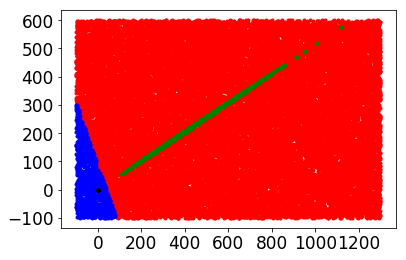

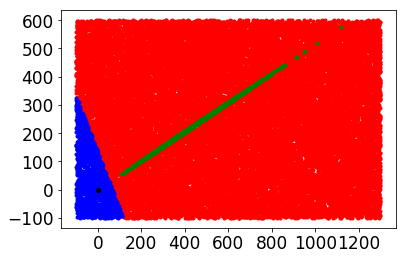

In [67]:
# 1000 epoch
plot_temp_all(feature_random, pre_label_nn,feature_t, label_t)
plot_temp_all(feature_random, pre_label_svm,feature_t, label_t)

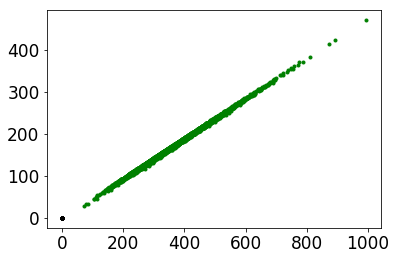

In [14]:
plot_temp(feature_t, label_t)

In [69]:
	plot_blobs_all_together(feature_random, pre_label_nn,feature_t, label_t,
		'../result/exploration/NN_decision_boundary_transform.png')
	plot_blobs_all_together(feature_random, pre_label_svm,feature_t, label_t,
		'../result/exploration/SVM_decision_boundary_transform.png')